### GLOBAL DATASETS


In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
!wget https://www.kaggle.com/rajeevw/ufcdata/download

--2019-11-27 04:53:12--  https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 405373 (396K) [application/x-httpd-php]
Saving to: ‘Metro_Interstate_Traffic_Volume.csv.gz’

Metro_Interstate_Tr 100%[===================>] 395.87K  1.53MB/s    in 0.3s    

2019-11-27 04:53:13 (1.53 MB/s) - ‘Metro_Interstate_Traffic_Volume.csv.gz’ saved [405373/405373]

--2019-11-27 04:53:14--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 579043 (565K) [application/x-httpd-php]
Saving to: ‘bank.zip’

bank.zip 

In [2]:
!pip install pymannkendall

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import os
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.tsa.arima_process as arima
import matplotlib.pyplot as plt
import numpy as np
import pymannkendall as mk
import zipfile
import numbers
from statsmodels.tsa.stattools import acf, pacf
import copy
import time
from datetime import datetime

In [4]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()
!cp kaggle.json ~/.kaggle/

Saving kaggle.json to kaggle.json


In [5]:
!ls -a ~/.kaggle

.  ..  kaggle.json


### J FUNCS

In [0]:
def analyze(serie, lags=20, plot=True, verbose=False):

  if len(serie)<lags:
    lags = int(np.floor(len(serie)/2))
    
  _, p = acorr_ljungbox(serie, lags=lags)
  
  acf_x, confint = acf(serie, nlags=lags, alpha=0.05, fft=False, unbiased=False)
  thrhld = 0.5
  signif = ((acf_x > (confint[:,1]-acf_x)) | (acf_x < (confint[:,0]-acf_x))) & ((acf_x > thrhld) | (acf_x < -thrhld))
  signif[0] = False
  result = sum([np.abs(x) for x, y in zip(acf_x, signif) if y == True])

  if plot:
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4,figsize=(35,3))

    ax1.plot(serie)

    plot_acf(serie, lags=lags, ax=ax2);

    plot_pacf(serie, lags=lags, ax=ax3);

    ax4.stem(p, basefmt=" ", use_line_collection=True)
    ax4.plot([0,lags],[0.05,0.05],'r')
  
    print("Autocorr = ",any(p<0.05))
    print(mk.original_test(serie))
  return any(p<0.05) and any(signif), result

def analyzeDB(df):
  columns = list(df) 
  test=[]
  acum_corr = []

  for i in columns: 
    if np.issubdtype(df[i].dtype, np.number):
      itest , iacum_corr = analyze(df[i], plot=False)
      test = np.append(test, itest)
      acum_corr = np.append(acum_corr, iacum_corr)
    else:
      test = np.append(test, 0)
      acum_corr = np.append(acum_corr, 0)

  cols = [x for x, y in zip(columns, test) if y == 1]
  acum_corr = [x for x, y in zip(acum_corr, test) if y == 1]
  if not acum_corr:
    acum_corr = [0]
  return cols, acum_corr

def analyzeDB_attGrouping(df, verbose=False):
  results = dict()

  for col in list(df):
    results[col] = dict()
    for att in df[col].unique():
      try:
        corr_att, corrs = analyzeDB(df.loc[df[col] == att]) 
        if corr_att and corrs:
          results[col][att] = [corr_att, corrs]
          if verbose:
            print("Attribute, value, length:",col, att, len(df.loc[df[col] == att]))
            print(corr_att)
            print(corrs)
      except:
        pass

  summary = copy.deepcopy(results)
  
  for key, value in results.items():
    list_n_corr_att = []
    list_max_corr = [0]
    acum_grouping = 0
    for key2, value2 in value.items():
      _, c = value2
      list_n_corr_att = np.append(list_n_corr_att, len(c))
      list_max_corr = np.append(list_max_corr, np.max(c))
      acum_grouping += len(df.loc[df[key] == key2])
    summary[key] = [int(100*acum_grouping/len(df)), len(list_n_corr_att), np.mean(list_n_corr_att), np.std(list_n_corr_att), np.mean(list_max_corr), np.max(list_max_corr)]

  t, c = analyzeDB(df) 
  summary['no-grouping'] = [100,1, len(t), 0, np.mean(c), np.max(c)]
  summary_df = pd.DataFrame.from_dict(summary, orient='index', columns=['% data','groups', 'avg_temp_att', 'std', 'avg_corr', 'max_corr'])
  print("Most probable grouping attribute is:",summary_df[['avg_temp_att']].idxmax().item())
  return summary_df, results

#### METRO DATA EXAMPLE

In [13]:
df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv.gz', compression='gzip')
df

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...,...
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450


In [14]:
X,Y = analyzeDB(df)
print(f'cols: {X}')
print(f'acum_corr: {Y}')

cols: ['temp', 'snow_1h', 'clouds_all', 'traffic_volume']
acum_corr: [17.181524524850357, 2.109439591692098, 4.5555072985055425, 2.237977718586252]


In [15]:
t,c = analyzeDB(df) 
l = []
l = np.append(l, len(c))
l2 = np.append(l, c)
maxl2=np.max(c)
[len(l), np.mean(l), np.std(l), np.mean(l2), maxl2]

[1, 4.0, 0.0, 6.01688982672685, 17.181524524850357]

In [16]:
analyzeDB_attGrouping(df)

Most probable grouping attribute is: holiday


(                     % data  groups  ...   avg_corr   max_corr
 holiday                  99       1  ...   8.589286  17.178572
 temp                     41    1303  ...   1.279268  14.062500
 rain_1h                  98      56  ...   2.975698  19.179688
 snow_1h                  99       5  ...   3.448541  17.179340
 clouds_all               99      34  ...   4.838004  18.470961
 weather_main             99       9  ...  12.540115  18.057473
 weather_description      99      24  ...   8.800022  17.522695
 date_time                 0       1  ...   0.416667   0.833333
 traffic_volume           12     391  ...   0.641085   1.127750
 no-grouping             100       1  ...   6.521112  17.181525
 
 [10 rows x 6 columns],
 {'clouds_all': {0: [['temp', 'traffic_volume'],
    [2.188126139100685, 0.7581818971918601]],
   1: [['temp', 'rain_1h', 'traffic_volume'],
    [17.758864224401073, 1.2294586780176275, 0.7726671589682274]],
   5: [['temp', 'rain_1h'], [15.913303114694301, 2.76005798839

In [17]:
print(df)

      holiday    temp  ...            date_time  traffic_volume
0        None  288.28  ...  2012-10-02 09:00:00            5545
1        None  289.36  ...  2012-10-02 10:00:00            4516
2        None  289.58  ...  2012-10-02 11:00:00            4767
3        None  290.13  ...  2012-10-02 12:00:00            5026
4        None  291.14  ...  2012-10-02 13:00:00            4918
...       ...     ...  ...                  ...             ...
48199    None  283.45  ...  2018-09-30 19:00:00            3543
48200    None  282.76  ...  2018-09-30 20:00:00            2781
48201    None  282.73  ...  2018-09-30 21:00:00            2159
48202    None  282.09  ...  2018-09-30 22:00:00            1450
48203    None  282.12  ...  2018-09-30 23:00:00             954

[48204 rows x 9 columns]


Autocorr =  True
Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=35.87119205014844, Tau=0.10892529282342671, s=126548175.0, var_s=12445723483611.0, slope=0.0001506818910454008)


(True, 17.181524524850357)

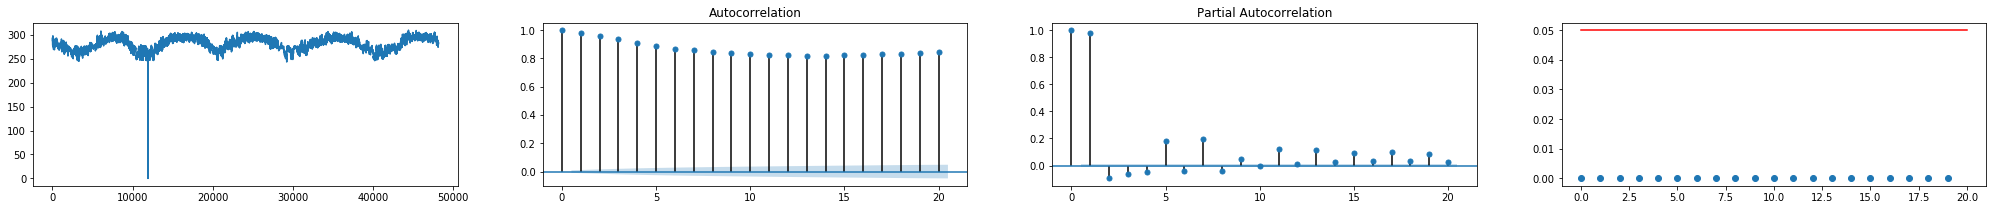

In [18]:
analyze(df["temp"])

Autocorr =  True
Mann_Kendall_Test(trend='decreasing', h=True, p=0.0, z=-11.904045830542405, Tau=-0.035043459098663333, s=-40713095.0, var_s=11697122425652.334, slope=0.0)


(True, 4.5555072985055425)

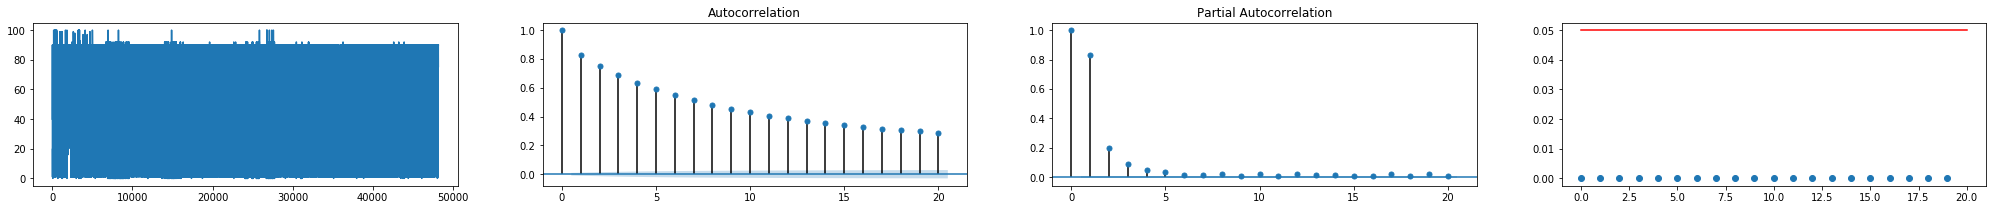

In [19]:
 analyze(df["clouds_all"])

Autocorr =  True
Mann_Kendall_Test(trend='no trend', h=False, p=0.11016574079351615, z=1.5974486255282063, Tau=0.004850761563523066, s=5635560.0, var_s=12445725032542.0, slope=0.0007606876616461281)


(True, 2.237977718586252)

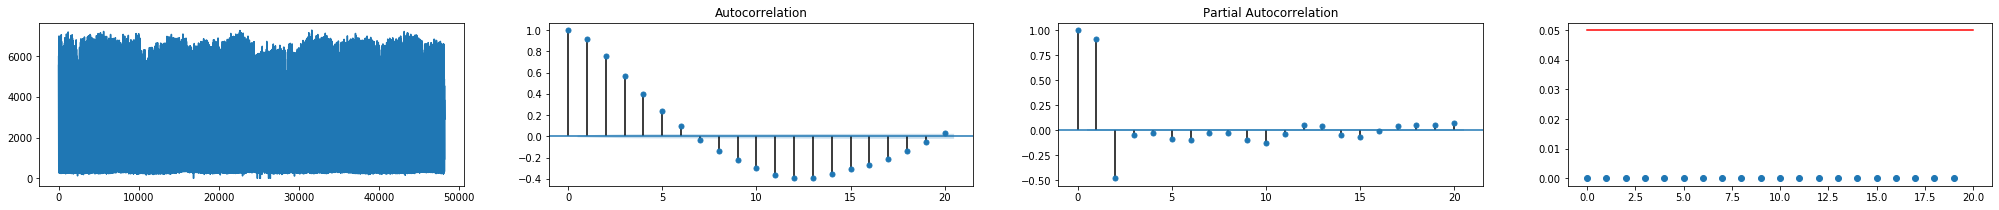

In [20]:
 analyze(df["traffic_volume"])

#### GENERATED EXAMPLES

Autocorr =  True
Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=47.35119492533284, Tau=1.0, s=499500.0, var_s=111277500.0, slope=1.0)


(True, 19.370087780087783)

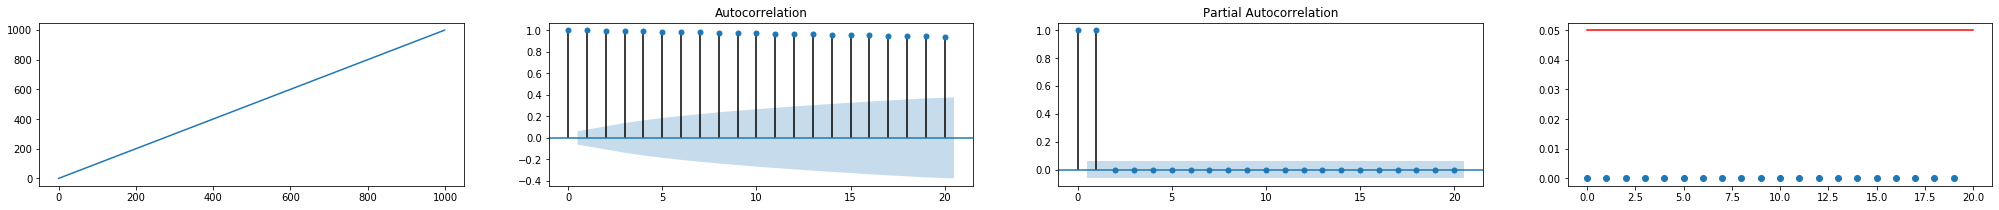

In [21]:
 analyze(np.arange(1000))

Autocorr =  True
Mann_Kendall_Test(trend='no trend', h=False, p=0.3573971789321233, z=-0.9203360441051379, Tau=-0.06262626262626263, s=-310.0, var_s=112726.0, slope=-1.1102230246251566e-17)


(True, 7.990044318780959)

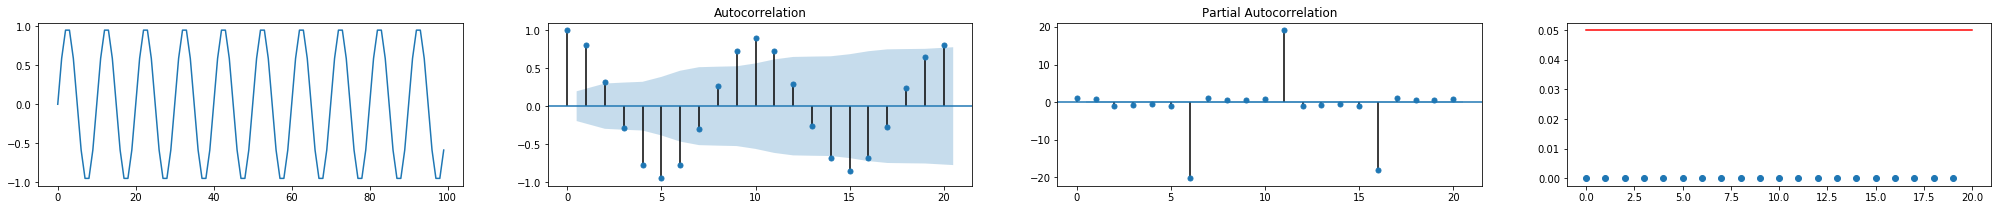

In [22]:
 analyze(np.sin(2*np.pi*0.1*np.arange(100)))

Autocorr =  True
Mann_Kendall_Test(trend='no trend', h=False, p=1.0, z=0, Tau=0.0, s=0.0, var_s=889554000.0, slope=0.0)


(True, 19.676522291522296)

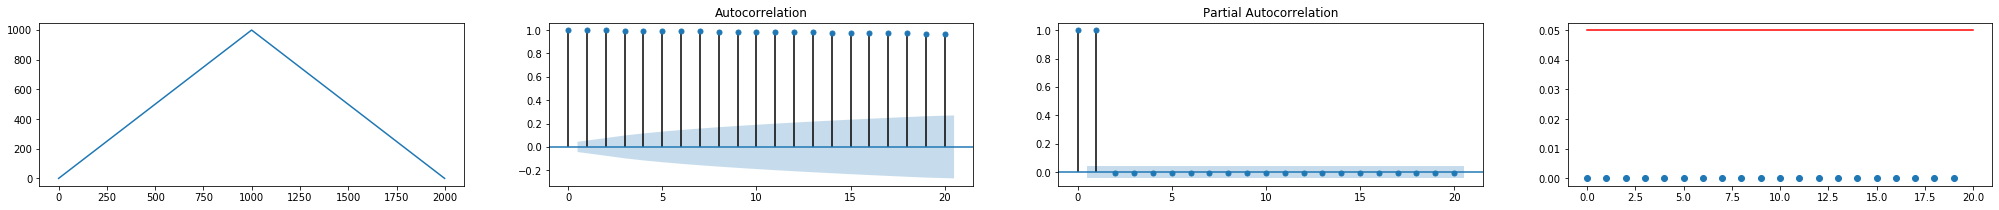

In [23]:
 analyze(np.concatenate([np.arange(1000),np.arange(1000)[::-1]]))

Autocorr =  False
Mann_Kendall_Test(trend='no trend', h=False, p=0.7235719574764377, z=0.3536890129237833, Tau=0.007471471471471472, s=3732.0, var_s=111277500.0, slope=1.107369895131513e-05)


(False, 0)

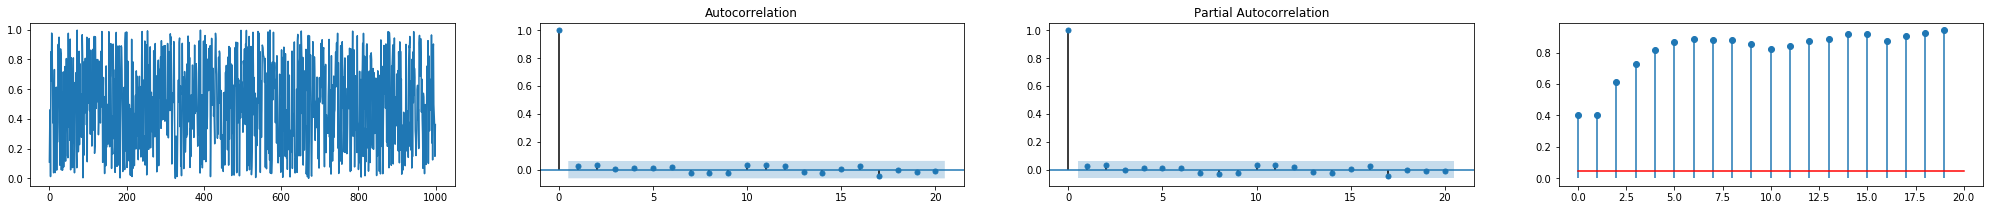

In [24]:
 analyze(np.random.rand(1000))

#### BANK DATA EXAMPLE

In [25]:
zf = zipfile.ZipFile('bank.zip') 
df = pd.read_csv(zf.open('bank.csv'),sep=';')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no


In [26]:
analyzeDB_attGrouping(df)

Most probable grouping attribute is: duration


(             % data  groups  avg_temp_att       std  avg_corr  max_corr
 age               0       0           NaN       NaN  0.000000  0.000000
 job               0       0           NaN       NaN  0.000000  0.000000
 marital           0       0           NaN       NaN  0.000000  0.000000
 education         0       0           NaN       NaN  0.000000  0.000000
 default           0       0           NaN       NaN  0.000000  0.000000
 balance           0       5      1.000000  0.000000  0.600060  0.826651
 housing           0       0           NaN       NaN  0.000000  0.000000
 loan              0       0           NaN       NaN  0.000000  0.000000
 contact           0       0           NaN       NaN  0.000000  0.000000
 day               0       0           NaN       NaN  0.000000  0.000000
 month             0       0           NaN       NaN  0.000000  0.000000
 duration         11      39      1.102564  0.303389  0.625107  0.825801
 campaign          0       0           NaN       Na

Autocorr =  False
Mann_Kendall_Test(trend='no trend', h=False, p=0.6572106867221352, z=0.4437675015623613, Tau=0.0043995278670041285, s=44952.0, var_s=10260481145.333334, slope=0.0)


(False, 0)

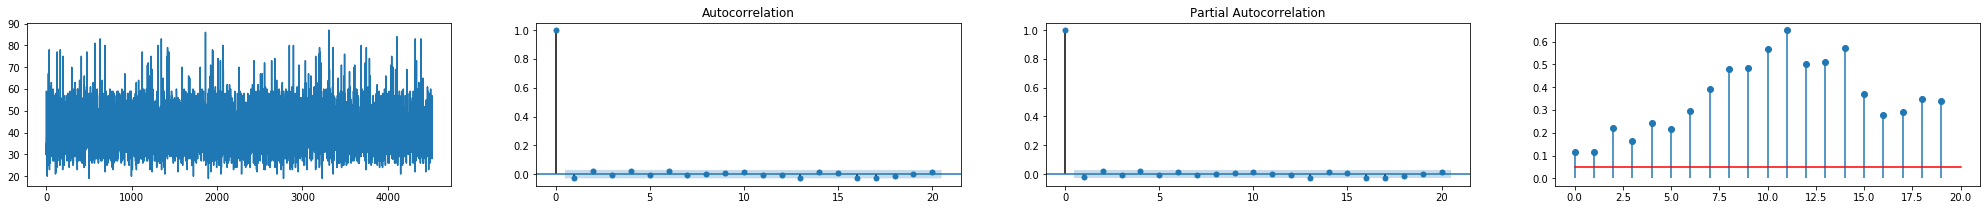

In [27]:
analyze(df['age'])

Autocorr =  False
Mann_Kendall_Test(trend='no trend', h=False, p=0.41288237244101067, z=-0.8188318220776378, Tau=-0.008119924129871808, s=-82965.0, var_s=10265732448.333334, slope=-0.0008514865578953461)


(False, 0)

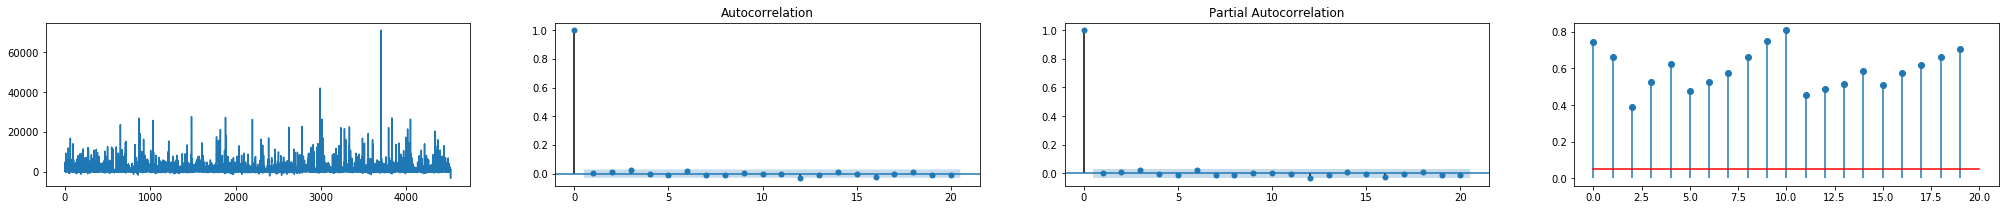

In [28]:
analyze(df['balance'])

Autocorr =  False
Mann_Kendall_Test(trend='no trend', h=False, p=0.8195963261306178, z=0.22806420621655552, Tau=0.002260542248269139, s=23097.0, var_s=10255557693.666666, slope=0.0)


(False, 0)

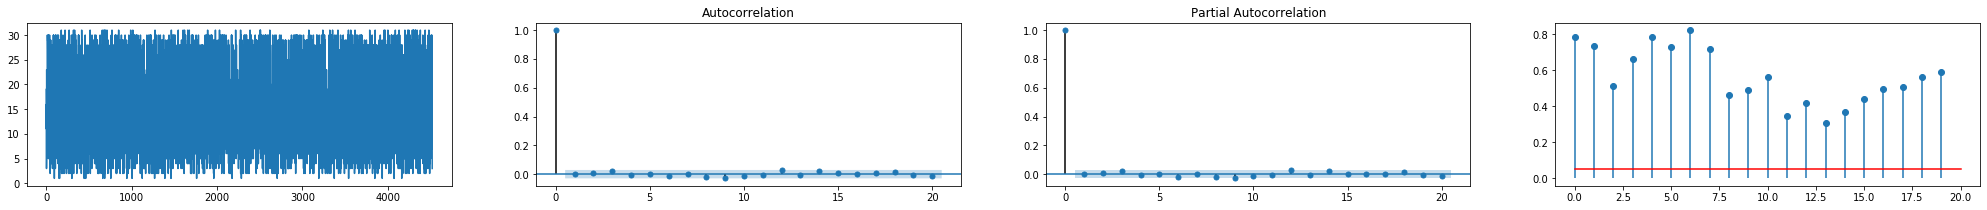

In [29]:
analyze(df['day'])

Autocorr =  True
Mann_Kendall_Test(trend='no trend', h=False, p=0.468596635540089, z=0.7247643081803159, Tau=0.00718887081525154, s=73452.0, var_s=10270742238.0, slope=0.001152073732718894)


(False, 0)

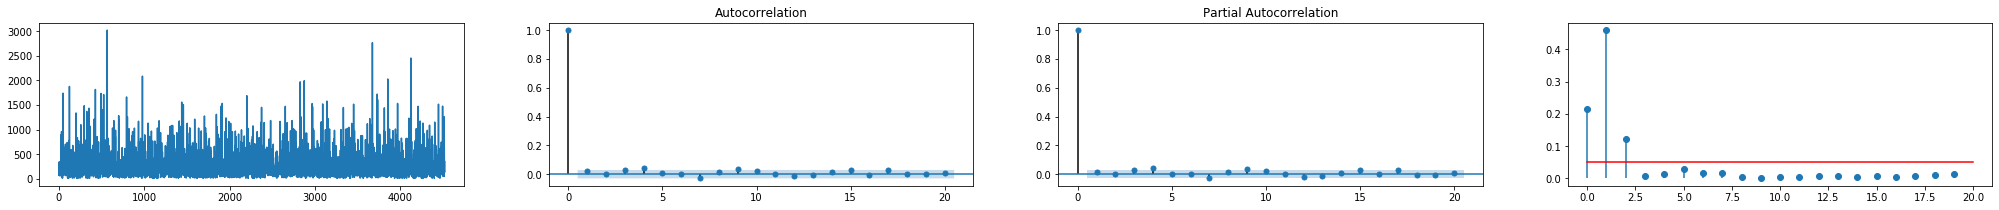

In [30]:
analyze(df['duration'])

Autocorr =  False
Mann_Kendall_Test(trend='no trend', h=False, p=0.36515766221908486, z=0.9055810130653715, Tau=0.008612414435681667, s=87997.0, var_s=9442157611.666666, slope=0.0)


(False, 0)

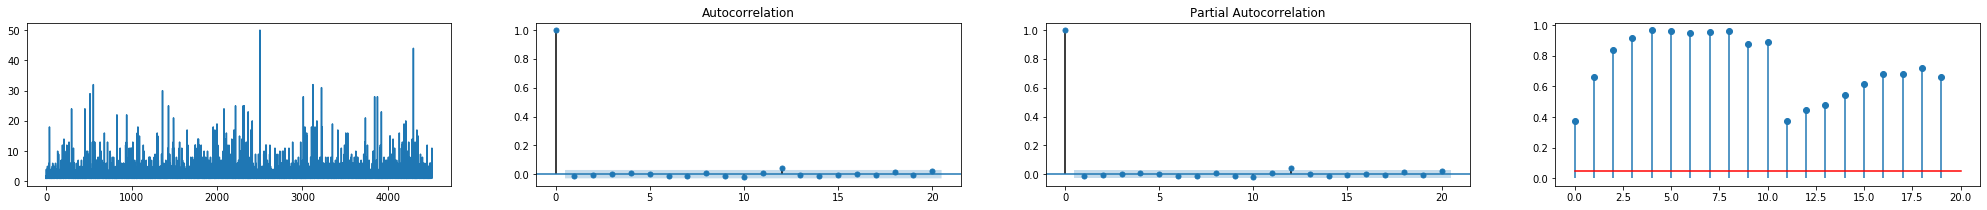

In [31]:
analyze(df['campaign'])

Autocorr =  False
Mann_Kendall_Test(trend='no trend', h=False, p=0.915033421892069, z=-0.10669188348592187, Tau=-0.0007096675690435783, s=-7251.0, var_s=4617567461.666667, slope=0.0)


(False, 0)

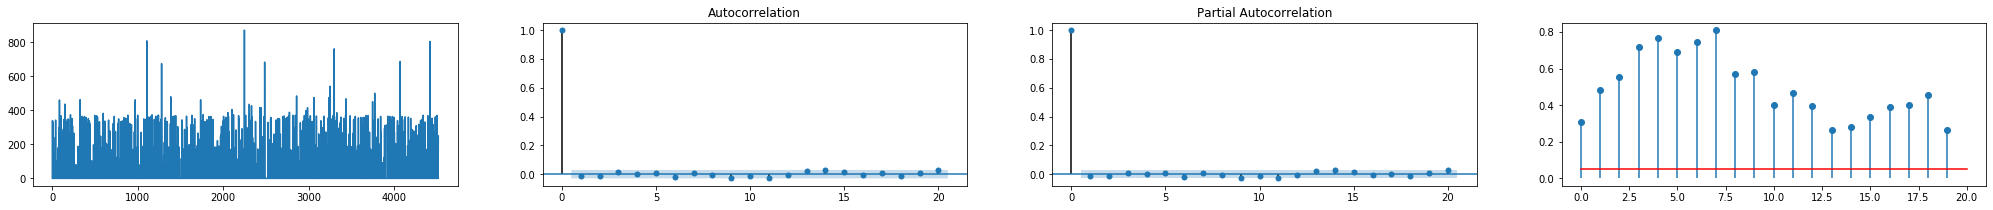

In [32]:
analyze(df['pdays'])

Autocorr =  False
Mann_Kendall_Test(trend='no trend', h=False, p=0.7521094736193961, z=-0.31585907845574623, Tau=-0.0020999348174595253, s=-21456.0, var_s=4613922653.333333, slope=0.0)


(False, 0)

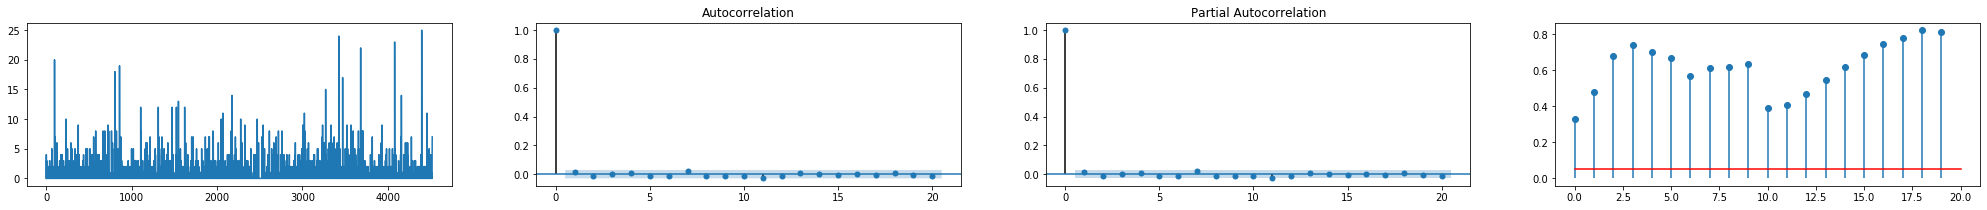

In [33]:
analyze(df['previous'])

#### MARKET ARRIVALS DATA EXAMPLE


In [34]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/MarketArrivals.csv')
df

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
0,ABOHAR(PB),January,2005,2350,404,493,446,PB,ABOHAR,January-2005
1,ABOHAR(PB),January,2006,900,487,638,563,PB,ABOHAR,January-2006
2,ABOHAR(PB),January,2010,790,1283,1592,1460,PB,ABOHAR,January-2010
3,ABOHAR(PB),January,2011,245,3067,3750,3433,PB,ABOHAR,January-2011
4,ABOHAR(PB),January,2012,1035,523,686,605,PB,ABOHAR,January-2012
...,...,...,...,...,...,...,...,...,...,...
10222,YEOLA(MS),December,2011,131326,282,612,526,MS,YEOLA,December-2011
10223,YEOLA(MS),December,2012,207066,485,1327,1136,MS,YEOLA,December-2012
10224,YEOLA(MS),December,2013,215883,472,1427,1177,MS,YEOLA,December-2013
10225,YEOLA(MS),December,2014,201077,446,1654,1456,MS,YEOLA,December-2014


In [35]:
analyzeDB_attGrouping(df)

Most probable grouping attribute is: year


(             % data  groups  avg_temp_att       std  avg_corr   max_corr
 market           89      82      3.268293  1.379721  1.724639  11.021943
 month           100      12      2.333333  0.471405  2.661403   3.441788
 year             98      20      3.650000  0.792149  1.631192   4.867641
 quantity          0       2      1.500000  0.500000  0.481537   0.751046
 priceMin          5      38      1.210526  0.467800  0.633745   0.852564
 priceMax          3      28      1.142857  0.349927  0.659545   0.892228
 priceMod          5      48      1.062500  0.242061  0.685336   0.879571
 state            93      16      3.000000  1.414214  4.443570  16.810140
 city             89      81      3.259259  1.385799  1.729695  11.021943
 date              0       5      1.000000  0.000000  0.570747   0.784514
 no-grouping     100       1      3.000000  0.000000  4.995772  13.816379,
 {'city': {'ABOHAR': [['priceMin', 'priceMax', 'priceMod'],
    [0.5593972698028469, 0.6015874594062273, 0.5982

In [36]:
df["month"] = df["month"].str.capitalize()
df["month"] = pd.to_datetime(df.month, format='%B', errors='coerce')
df = df.sort_values(by=['year', 'month'])
analyzeDB_attGrouping(df)

Most probable grouping attribute is: city


(             % data  groups  avg_temp_att       std   avg_corr   max_corr
 market           98      98      4.265306  1.025701   7.597219  17.380627
 month           100      12      3.250000  0.433013  17.350342  18.922796
 year             88      18      2.111111  0.566558   9.423703  16.693016
 quantity          0       3      1.000000  0.000000   0.506559   0.715559
 priceMin         43     259      1.193050  0.513702   0.982610  16.380649
 priceMax         18     150      1.100000  0.321455   0.781450   2.429405
 priceMod         26     204      1.088235  0.300423   0.763984   2.519834
 state            99      19      4.263158  0.713929  13.466990  19.762833
 city             99      96      4.281250  1.027772   7.757305  17.380627
 date              0       5      1.000000  0.000000   0.570747   0.784514
 no-grouping     100       1      4.000000  0.000000  16.322876  19.874453,
 {'city': {'ABOHAR': [['year', 'priceMin', 'priceMax', 'priceMod'],
    [6.678875691810212,
     1.

In [37]:
df

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
5399,LASALGAON(MS),1900-01-01,1996,225063,160,257,226,MS,LASALGAON,January-1996
5420,LASALGAON(MS),1900-02-01,1996,196164,133,229,186,MS,LASALGAON,February-1996
5441,LASALGAON(MS),1900-03-01,1996,178992,155,274,243,MS,LASALGAON,March-1996
5461,LASALGAON(MS),1900-04-01,1996,192592,136,279,254,MS,LASALGAON,April-1996
5481,LASALGAON(MS),1900-05-01,1996,237574,154,312,269,MS,LASALGAON,May-1996
...,...,...,...,...,...,...,...,...,...,...
9610,SURAT(GUJ),1900-02-01,2016,29450,697,1269,983,GUJ,SURAT,February-2016
9799,UDAIPUR(RAJ),1900-02-01,2016,4422,289,1006,656,RAJ,UDAIPUR,February-2016
9920,VANI(MS),1900-02-01,2016,42275,522,1006,688,MS,VANI,February-2016
10004,VARANASI(UP),1900-02-01,2016,17300,1415,1465,1433,UP,VARANASI,February-2016


Autocorr =  True
Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=141.71192409817647, Tau=0.9319696364078542, s=48733299.0, var_s=118260256493.66667, slope=0.001370374984427557)


(True, 19.874452653618505)

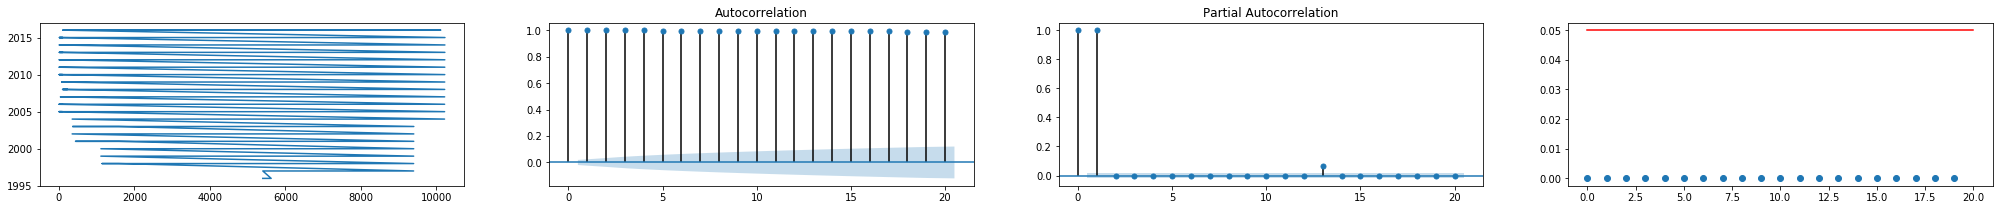

In [38]:
analyze(df['year'])

Autocorr =  True
Mann_Kendall_Test(trend='no trend', h=False, p=0.5984922273966302, z=-0.5265700031865623, Tau=-0.0034719016980683604, s=-181548.0, var_s=118868264770.0, slope=-0.04009703196347032)


(False, 0)

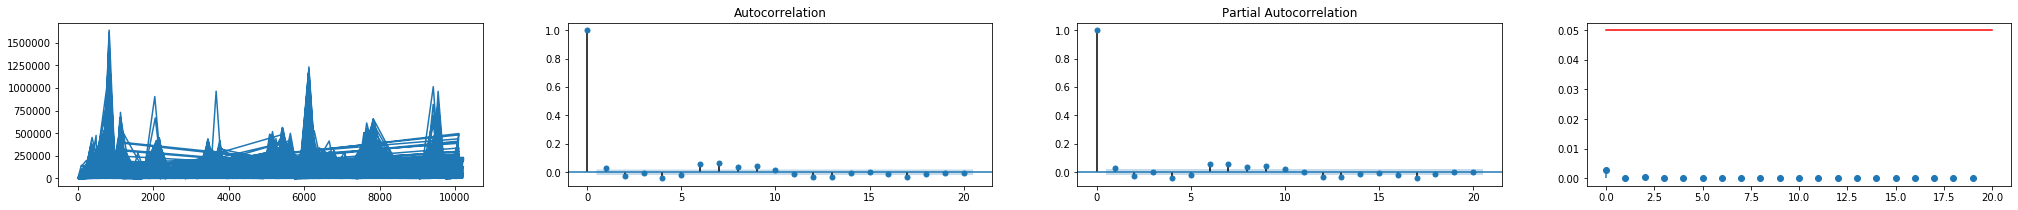

In [39]:
analyze(df['quantity'])

Autocorr =  True
Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=56.2216125026126, Tau=0.37068811784347455, s=19383523.0, var_s=118866311905.0, slope=0.07051282051282051)


(True, 10.871568362548777)

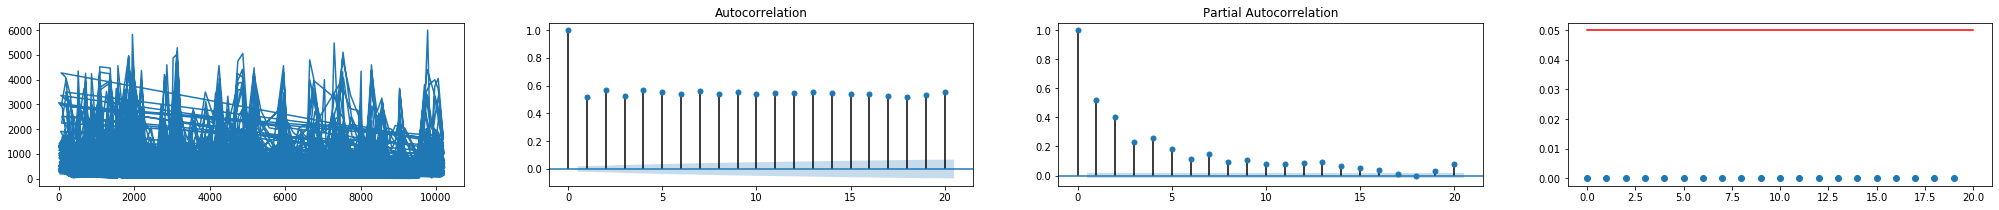

In [40]:
analyze(df['priceMin'])

Autocorr =  True
Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=77.01756420011652, Tau=0.507806816174463, s=26553549.0, var_s=118868164915.66667, slope=0.14506096043791988)


(True, 17.6543738886615)

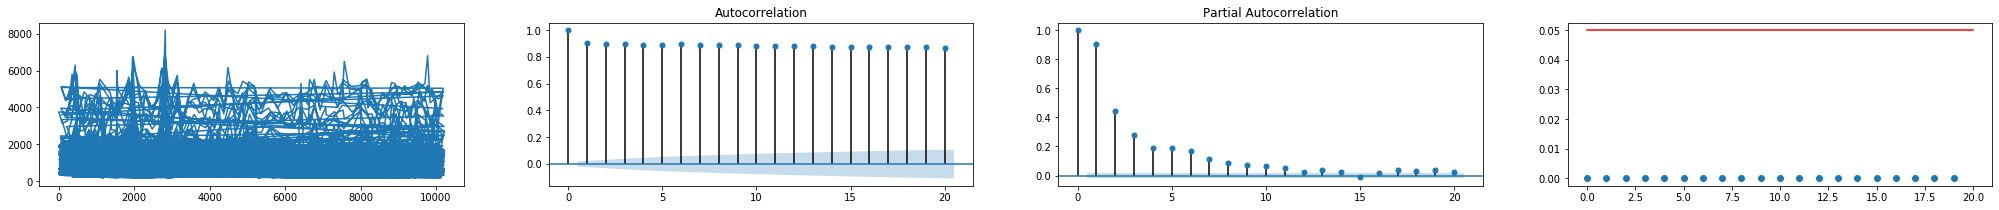

In [41]:
analyze(df['priceMax'])

Autocorr =  True
Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=73.65445119565943, Tau=0.4856324508180248, s=25394037.0, var_s=118868139716.33333, slope=0.11588666029926775)


(True, 16.891107439480166)

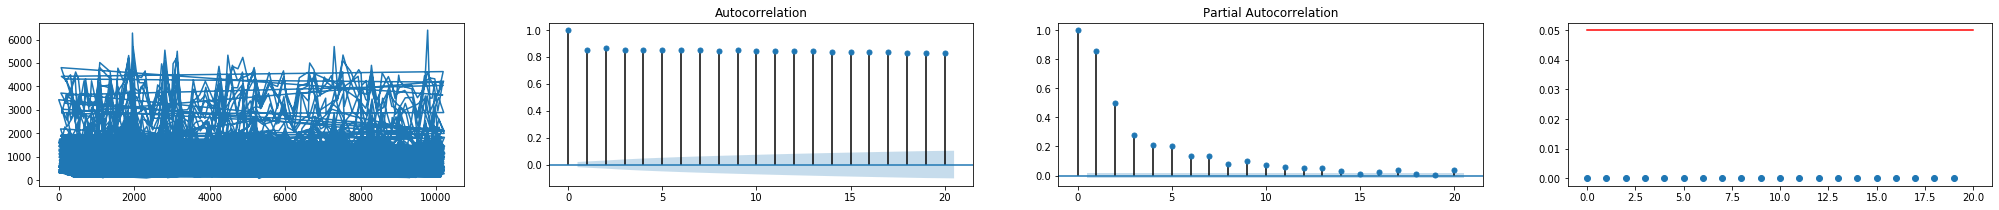

In [42]:
analyze(df['priceMod'])

In [43]:
label_analysis(df)

NameError: ignored

#### UFC DATA EXAMPLE

In [0]:
!kaggle datasets download -d rajeevw/ufcdata
zf = zipfile.ZipFile('ufcdata.zip') 
df = pd.read_csv(zf.open('data.csv'),sep=',')
df

  0% 0.00/2.52M [00:00<?, ?B/s]
100% 2.52M/2.52M [00:00<00:00, 85.8MB/s]


,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_DISTANCE_att,B_avg_DISTANCE_landed,B_avg_GROUND_att,B_avg_GROUND_landed,B_avg_HEAD_att,B_avg_HEAD_landed,B_avg_KD,B_avg_LEG_att,B_avg_LEG_landed,B_avg_PASS,B_avg_REV,B_avg_SIG_STR_att,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,B_avg_TD_att,B_avg_TD_landed,B_avg_TD_pct,B_avg_TOTAL_STR_att,B_avg_TOTAL_STR_landed,B_longest_win_streak,B_losses,B_avg_opp_BODY_att,B_avg_opp_BODY_landed,...,R_avg_opp_BODY_att,R_avg_opp_BODY_landed,R_avg_opp_CLINCH_att,R_avg_opp_CLINCH_landed,R_avg_opp_DISTANCE_att,R_avg_opp_DISTANCE_landed,R_avg_opp_GROUND_att,R_avg_opp_GROUND_landed,R_avg_opp_HEAD_att,R_avg_opp_HEAD_landed,R_avg_opp_KD,R_avg_opp_LEG_att,R_avg_opp_LEG_landed,R_avg_opp_PASS,R_avg_opp_REV,R_avg_opp_SIG_STR_att,R_avg_opp_SIG_STR_landed,R_avg_opp_SIG_STR_pct,R_avg_opp_SUB_ATT,R_avg_opp_TD_att,R_avg_opp_TD_landed,R_avg_opp_TD_pct,R_avg_opp_TOTAL_STR_att,R_avg_opp_TOTAL_STR_landed,R_total_rounds_fought,R_total_time_fought(seconds),R_total_title_bouts,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Henry Cejudo,Marlon Moraes,Marc Goddard,2019-06-08,"Chicago, Illinois, USA",Red,True,Bantamweight,5,0.0,4.0,0.0,9.200000,6.000000,0.200000,0.000000,62.600000,20.600000,2.600000,2.000000,48.600000,11.200000,0.800000,7.6,5.400000,0.400000,0.000000,65.40,22.600000,0.466000,0.400000,0.80000,0.200000,0.100000,66.400000,23.600000,4.0,1.0,6.400000,4.000000,...,13.300000,8.800000,7.500000,5.100000,90.500000,26.800000,0.800000,0.300000,76.100000,17.300000,0.100000,9.400000,6.100000,0.000000,0.000000,98.800000,32.200000,0.336000,0.000000,0.900000,0.100000,0.050000,110.500000,43.300000,27.0,742.60,3.0,0.0,2.0,4.0,2.0,0.0,0.0,8.0,Orthodox,162.56,162.56,135.0,31.0,32.0
1,Valentina Shevchenko,Jessica Eye,Robert Madrigal,2019-06-08,"Chicago, Illinois, USA",Red,True,Women's Flyweight,5,0.0,3.0,0.0,14.600000,9.100000,11.800000,7.300000,124.700000,42.100000,2.400000,1.900000,112.000000,32.000000,0.000000,12.3,10.200000,0.800000,0.000000,138.90,51.300000,0.399000,0.700000,1.00000,0.500000,0.225000,158.700000,69.600000,3.0,6.0,13.000000,9.300000,...,24.571429,14.142857,10.571429,7.857143,98.571429,32.571429,6.428571,4.285714,61.857143,12.428571,0.000000,29.142857,18.142857,1.142857,0.000000,115.571429,44.714286,0.437143,0.285714,3.285714,0.857143,0.147143,158.142857,82.285714,25.0,1062.00,2.0,0.0,1.0,2.0,0.0,2.0,0.0,5.0,Southpaw,165.10,167.64,125.0,32.0,31.0
2,Tony Ferguson,Donald Cerrone,Dan Miragliotta,2019-06-08,"Chicago, Illinois, USA",Red,False,Lightweight,3,0.0,3.0,0.0,15.354839,11.322581,6.741935,4.387097,84.741935,38.580645,5.516129,3.806452,67.645161,23.258065,0.645161,14.0,12.193548,0.935484,0.096774,97.00,46.774194,0.496129,0.354839,2.16129,0.677419,0.295484,103.709677,52.548387,8.0,8.0,17.903226,11.870968,...,14.466667,8.133333,2.800000,0.733333,91.066667,32.200000,4.866667,2.800000,78.266667,23.200000,0.266667,6.000000,4.400000,0.333333,0.133333,98.733333,35.733333,0.340000,0.066667,2.866667,0.666667,0.131333,102.133333,38.600000,33.0,604.40,2.0,0.0,1.0,3.0,3.0,6.0,1.0,14.0,Orthodox,180.34,193.04,155.0,36.0,35.0
3,Jimmie Rivera,Petr Yan,Kevin MacDonald,2019-06-08,"Chicago, Illinois, USA",Blue,False,Bantamweight,3,0.0,4.0,0.0,17.000000,14.000000,13.750000,11.000000,109.500000,48.750000,13.000000,10.500000,116.250000,53.750000,0.500000,3.0,2.500000,0.500000,0.250000,136.25,70.250000,0.550000,0.250000,2.50000,1.250000,0.287500,154.750000,86.750000,4.0,0.0,12.250000,6.000000,...,20.250000,13.375000,6.875000,5.625000,103.125000,38.500000,0.875000,0.750000,77.375000,20.375000,0.125000,13.250000,11.125000,0.000000,0.000000,110.875000,44.875000,0.446250,0.000000,2.375000,0.000000,0

In [0]:
df['R_fighter']

0               Henry Cejudo
1       Valentina Shevchenko
2              Tony Ferguson
3              Jimmie Rivera
4                Tai Tuivasa
                ...         
5139          Gerard Gordeau
5140            Ken Shamrock
5141            Royce Gracie
5142            Kevin Rosier
5143          Gerard Gordeau
Name: R_fighter, Length: 5144, dtype: object

In [0]:
analyzeDB_attGrouping(df)

Autocorr =  False
Mann_Kendall_Test(trend='decreasing', h=True, p=0.0, z=-15.453443222812425, Tau=-0.1442158773272065, s=-1860480.0, var_s=14494359304.0, slope=-0.000598623166716552)


(False, 0)

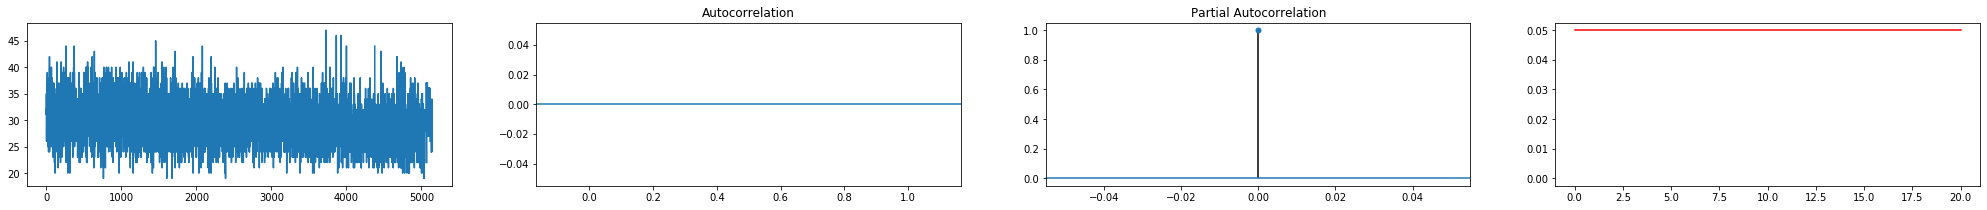

In [0]:
analyze(df['R_age'])

Autocorr =  True
Mann_Kendall_Test(trend='decreasing', h=True, p=5.467415409299292e-10, z=-6.205065421043733, Tau=-0.924901185770751, s=-234.0, var_s=1410.0, slope=-0.5)


(True, 1.6360416427670068)

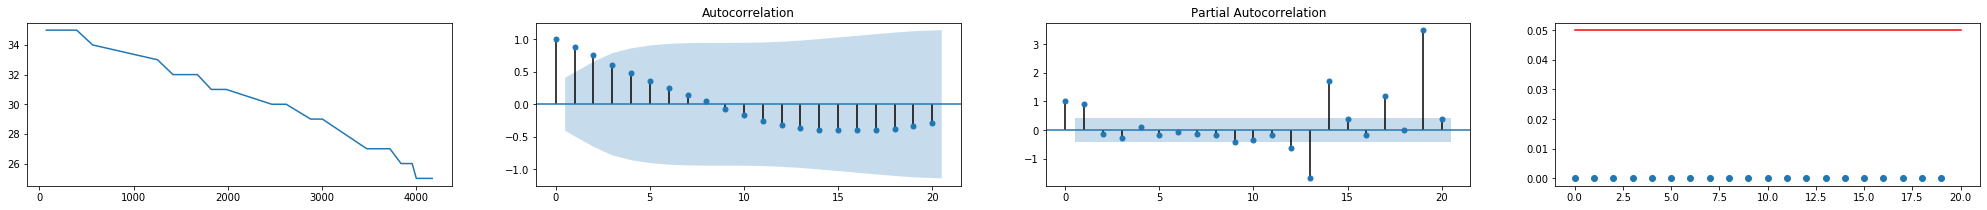

In [0]:
analyze(df.loc[df['R_fighter'] == 'Jim Miller']['R_age'])

In [0]:
arparams = np.array([0, 0])
maparams = np.array([1, .0])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag
y = arima.arma_generate_sample(ar, ma, 250)
analyze(y);

In [0]:
acorr_ljungbox(y)

#### AFRICA ECONOMIC DATA EXAMPLE

In [0]:

!kaggle datasets download -d chirin/africa-economic-banking-and-systemic-crisis-data
zf = zipfile.ZipFile('africa-economic-banking-and-systemic-crisis-data.zip') 
df = pd.read_csv(zf.open('african_crises.csv'),sep=',')
df

  0% 0.00/13.7k [00:00<?, ?B/s]
100% 13.7k/13.7k [00:00<00:00, 22.9MB/s]


,case,cc3,country,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,banking_crisis
0,1,DZA,Algeria,1870,1,0.052264,0,0,0.0,3.441456,0,0,0,crisis
1,1,DZA,Algeria,1871,0,0.052798,0,0,0.0,14.149140,0,0,0,no_crisis
2,1,DZA,Algeria,1872,0,0.052274,0,0,0.0,-3.718593,0,0,0,no_crisis
3,1,DZA,Algeria,1873,0,0.051680,0,0,0.0,11.203897,0,0,0,no_crisis
4,1,DZA,Algeria,1874,0,0.051308,0,0,0.0,-3.848561,0,0,0,no_crisis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054,70,ZWE,Zimbabwe,2009,1,354.800000,1,1,0.0,-7.670000,1,1,0,crisis
1055,70,ZWE,Zimbabwe,2010,0,378.200000,1,1,0.0,3.217000,1,0,0,no_crisis
1056,70,ZWE,Zimbabwe,2011,0,361.900000,1,1,0.0,4.920000,1,0,0,no_crisis
1057,70,ZWE,Zimbabwe,2012,0,361.900000,1,1,0.0,3.720000,1,0,0,no_crisis


In [0]:
analyzeDB(df)

(['case',
  'year',
  'systemic_crisis',
  'exch_usd',
  'domestic_debt_in_default',
  'sovereign_external_debt_default',
  'gdp_weighted_default',
  'independence',
  'inflation_crises'],
 [19.471801540525494,
  8.77845356172783,
  1.4069694665271957,
  9.0874683089836,
  4.333919085780502,
  2.821553197235753,
  0.5967619441207926,
  5.783509256203152,
  1.2114954005757776])

Autocorr =  True
Mann_Kendall_Test(trend='increasing', h=True, p=0.025639720065859573, z=2.231625572148704, Tau=0.03305183225606066, s=18516.0, var_s=68834280.0, slope=0.0)


(True, 5.783509256203152)

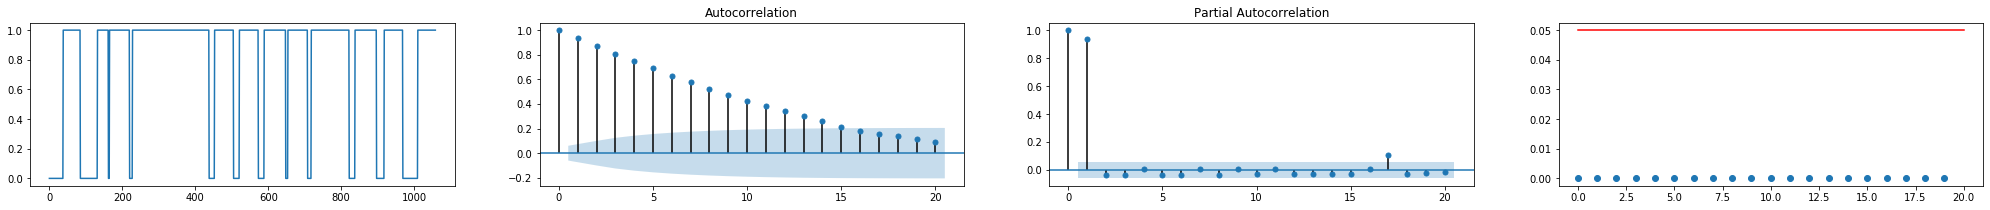

In [0]:
analyze(df['independence'])

Autocorr =  True
Mann_Kendall_Test(trend='increasing', h=True, p=3.1086244689504383e-15, z=7.888762746546097, Tau=0.5002801120448179, s=1786.0, var_s=51198.666666666664, slope=0.011976477337923121)


(True, 5.99682497859166)

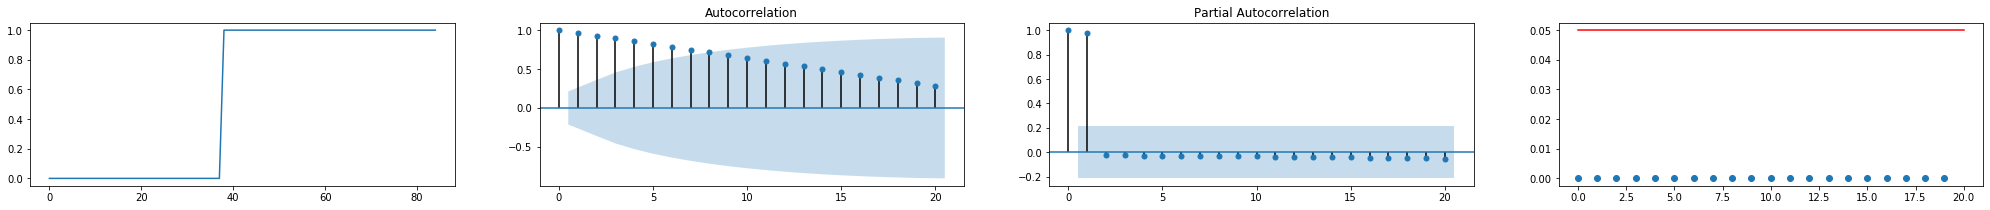

In [0]:
analyze(df.loc[df['country'] == 'Algeria']['independence'])

In [0]:
analyze(df.sort_values(by=['year']))

ValueError: ignored

In [0]:
analyze(df.sort_values(by=['year'])['year'])

In [0]:
t,c = analyzeDB(df) 
print(t)
print(c)

In [0]:
for val in df['country'].unique():
  t,c = analyzeDB(df.loc[df['country'] == val]) 
  print(t)
  print(c)

['year', 'exch_usd', 'sovereign_external_debt_default', 'gdp_weighted_default', 'inflation_annual_cpi', 'independence', 'currency_crises', 'inflation_crises']
[5.746845419697346, 5.836804392478186, 1.4593447505584511, 1.459344750558452, 0.62044503034621, 5.99682497859166, 0.5015307877536983, 0.5701148064859747]
['year', 'exch_usd', 'domestic_debt_in_default', 'sovereign_external_debt_default', 'inflation_annual_cpi', 'independence', 'currency_crises', 'inflation_crises']
[6.005154413660109, 3.9243876256935737, 2.097152847152847, 3.048139360639361, 0.5716145179753153, 5.834558349451964, 2.3354037267080736, 2.96848249789426]
['year', 'systemic_crisis', 'exch_usd', 'sovereign_external_debt_default', 'independence']
[4.2262911809037496, 2.0103308669551856, 3.1162562608294344, 4.133772204806688, 0.6657262277951933]
['year', 'systemic_crisis', 'exch_usd', 'sovereign_external_debt_default', 'independence']
[5.003360215053764, 0.73197471078827, 2.185331867536757, 3.6954988892108567, 2.23614718

#### EUROPEAN SOCIAL DATA EXAMPLE

In [0]:
!kaggle datasets download -d pascalbliem/european-social-survey-ess-8-ed21-201617
zf = zipfile.ZipFile('european-social-survey-ess-8-ed21-201617.zip') 
df = pd.read_csv(zf.open('ESS8e02.1_F1.csv'),sep=',')

 87% 9.00M/10.3M [00:00<00:00, 14.9MB/s]
100% 10.3M/10.3M [00:00<00:00, 19.1MB/s]


In [0]:
df

,name,essround,edition,proddate,idno,cntry,nwspol,netusoft,netustm,ppltrst,pplfair,pplhlp,polintr,psppsgva,actrolga,psppipla,cptppola,trstprl,trstlgl,trstplc,trstplt,trstprt,trstep,trstun,vote,prtvtbat,prtvtcbe,prtvtfch,prtvtdcz,prtvede1,prtvede2,prtvtfee,prtvtdes,prtvtdfi,prtvtcfr,prtvtbgb,prtvtehu,prtvtbie,prtvtcil,prtvtbis,...,anctry1,anctry2,ipcrtiv,imprich,ipeqopt,ipshabt,impsafe,impdiff,ipfrule,ipudrst,ipmodst,ipgdtim,impfree,iphlppl,ipsuces,ipstrgv,ipadvnt,ipbhprp,iprspot,iplylfr,impenv,imptrad,impfun,region,regunit,intewde,inwdds,inwmms,inwyys,inwshh,inwsmm,inwdde,inwmme,inwyye,inwehh,inwemm,inwtm,dweight,pspwght,pweight
0,ESS8e02_1,8,2.1,01.12.2018,1,AT,120,4,180,8,8,3,1,2,2,2,3,6,7,0,2,8,9,10,3,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11070,555555,2,6,1,2,2,3,5,1,2,4,3,1,2,6,3,6,1,1,1,6,3,AT13,2,NaN,5,12,2016,7,37,5,12,2016,8,33,50.0,0.611677,1.178496,0.370393
1,ESS8e02_1,8,2.1,01.12.2018,2,AT,120,5,120,6,6,5,1,1,3,2,3,5,4,3,3,4,6,7,3,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11070,555555,3,6,2,3,5,3,5,3,4,3,2,3,3,4,5,5,2,2,2,5,5,AT13,2,NaN,25,11,2016,9,39,25,11,2016,11,10,86.0,1.223354,0.899472,0.370393
2,ESS8e02_1,8,2.1,01.12.2018,4,AT,30,2,6666,5,6,4,3,2,2,2,2,3,5,9,3,3,4,5,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11010,555555,3,5,2,4,1,6,5,2,3,2,2,3,6,1,6,3,3,1,2,2,3,AT31,2,NaN,22,11,2016,17,17,22,11,2016,18,0,38.0,0.389058,0.315753,0.370393
3,ESS8e02_1,8,2.1,01.12.2018,6,AT,30,5,120,6,5,6,2,3,2,3,4,1,1,2,1,1,1,1,7,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11010,555555,2,3,2,2,2,3,3,2,2,2,2,3,3,2,3,4,2,2,3,2,2,AT13,2,NaN,11,10,2016,19,9,11,10,2016,19,59,46.0,0.642594,0.472467,0.370393
4,ESS8e02_1,8,2.1,01.12.2018,10,AT,30,5,180,5,5,7,3,3,3,4,1,7,7,10,6,7,9,10,2,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23000,555555,3,4,1,4,3,3,5,3,1,1,1,1,3,4,5,2,3,1,1,4,1,AT22,2,NaN,1,12,2016,10,31,1,12,2016,11,49,70.0,3.432402,2.246706,0.370393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44382,ESS8e02_1,8,2.1,01.12.2018,1303,SI,90,2,6666,1,2,1,2,1,4,1,4,0,0,3,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14120,555555,1,2,3,2,1,1,5,4,2,1,1,1,1,1,1,2,2,1,2,1,1,SI016,3,NaN,19,10,2016,7,30,19,10,2016,8,37,62.0,1.000000,0.835442,0.134491
44383,ESS8e02_1,8,2.1,01.12.2018,1304,SI,40,5,120,3,5,2,2,2,2,1,2,0,0,2,0,1,5,5,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14030,555555,1,4,2,2,2,3,2,2,3,3,1,1,1,1,4,1,2,1,1,1,2,SI011,3,NaN,30,9,2016,8,38,30,9,2016,9,45,60.0,1.000000,0.756328,0.134491
44384,ESS8e02_1,8,2.1,01.12.2018,1305,SI,240,5,150,3,3,4,2,2,2,1,2,3,5,9,1,1,2,5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14120,555555,2,6,1,1,1,2,1,2,1,4,1,2,2,2,4,1,1,2,1,2,5,SI011,3,NaN,26,9,2016,9,9,26,9,2016,10,17,62.0,1.000000,0.856172,0.134491
44385,ESS8e02_1,8,2.1,01.12.2018,1306,SI,0,5,120,5,5,5,3,2,5,2,5,1,6,5,1,1,1,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14120,555555,2,3,2,2,2,1,5,2,2,1,1,1,1,1,2,3,1,3,2,4,1,SI011,3,NaN,2,11,2016,17,0,2,11,2016,18,25,78.0,1.000000,0.756328,0.134491


In [0]:
t,c = analyzeDB(df) 
print(t)
print(c)

Autocorr =  True
Mann_Kendall_Test(trend='decreasing', h=True, p=4.218847493575595e-14, z=-7.553738775492829, Tau=-0.02115586285509681, s=-20840232.0, var_s=7611690712742.0, slope=0.0)


(False, 0)

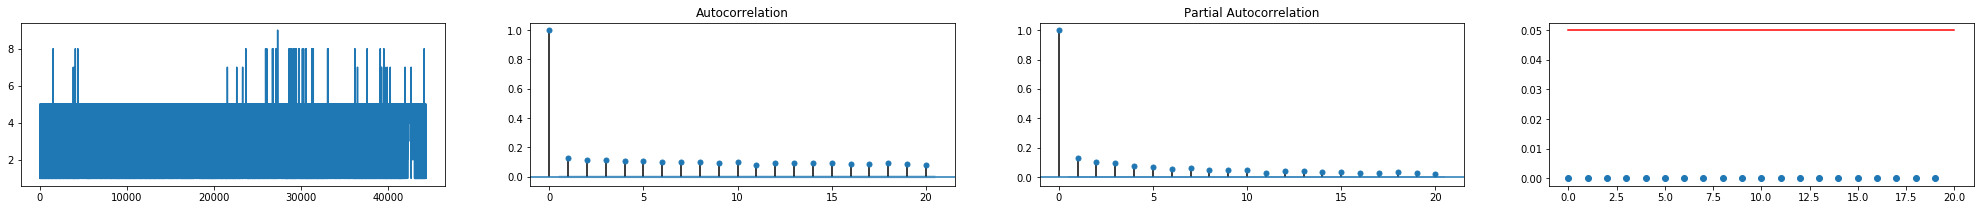

In [0]:
analyze(df['netusoft'])

#### INDIA TRADE DATA EXAMPLE

In [0]:
!kaggle datasets download -d lakshyaag/india-trade-data
zf = zipfile.ZipFile('india-trade-data.zip') 
df = pd.read_csv(zf.open('2018-2010_export.csv'),sep=',')
df

india-trade-data.zip: Skipping, found more recently modified local copy (use --force to force download)


,HSCode,Commodity,value,country,year
0,2,MEAT AND EDIBLE MEAT OFFAL.,0.18,AFGHANISTAN TIS,2018
1,3,"FISH AND CRUSTACEANS, MOLLUSCS AND OTHER AQUAT...",0.00,AFGHANISTAN TIS,2018
2,4,DAIRY PRODUCE; BIRDS' EGGS; NATURAL HONEY; EDI...,12.48,AFGHANISTAN TIS,2018
3,6,LIVE TREES AND OTHER PLANTS; BULBS; ROOTS AND ...,0.00,AFGHANISTAN TIS,2018
4,7,EDIBLE VEGETABLES AND CERTAIN ROOTS AND TUBERS.,1.89,AFGHANISTAN TIS,2018
...,...,...,...,...,...
137018,95,"TOYS, GAMES AND SPORTS REQUISITES; PARTS AND A...",0.03,ZIMBABWE,2010
137019,96,MISCELLANEOUS MANUFACTURED ARTICLES.,0.45,ZIMBABWE,2010
137020,97,WORKS OF ART COLLECTORS' PIECES AND ANTIQUES.,0.00,ZIMBABWE,2010
137021,98,PROJECT GOODS; SOME SPECIAL USES.,0.00,ZIMBABWE,2010


In [0]:
t,c = analyzeDB(df) 
print(t)
print(c)

['HSCode', 'year']
[4.394116490855901, 19.99539494914013]


Autocorr =  False
Mann_Kendall_Test(trend='no trend', h=False, p=0.7879780779284882, z=-0.2689371113746626, Tau=-0.007138776422663255, s=-1437.0, var_s=28510669.0, slope=-4.587155963302753e-05)


(False, 0)

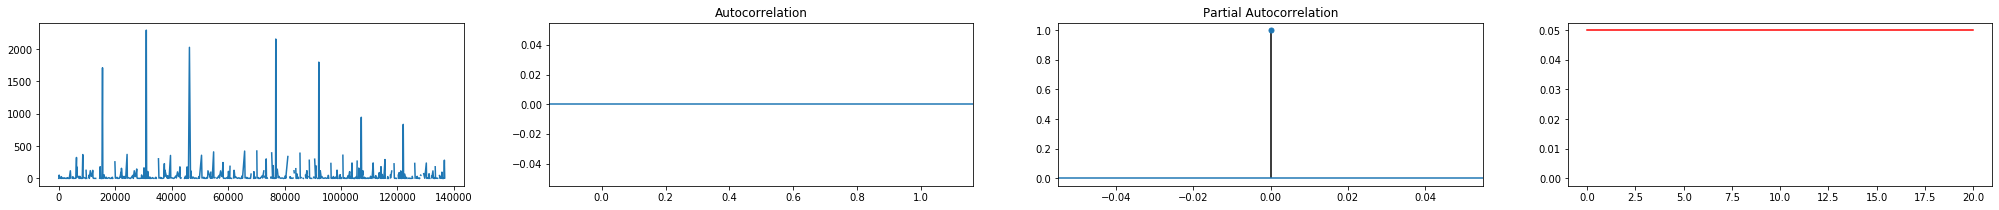

In [0]:
analyze(df.loc[df['Commodity'] == 'MEAT AND EDIBLE MEAT OFFAL.']['value'])

Autocorr =  True
Mann_Kendall_Test(trend='decreasing', h=True, p=0.0, z=-36.48720667971042, Tau=-0.8886571160117974, s=-244961.0, var_s=45072237.0, slope=-0.012048192771084338)


(True, 19.179853042884258)

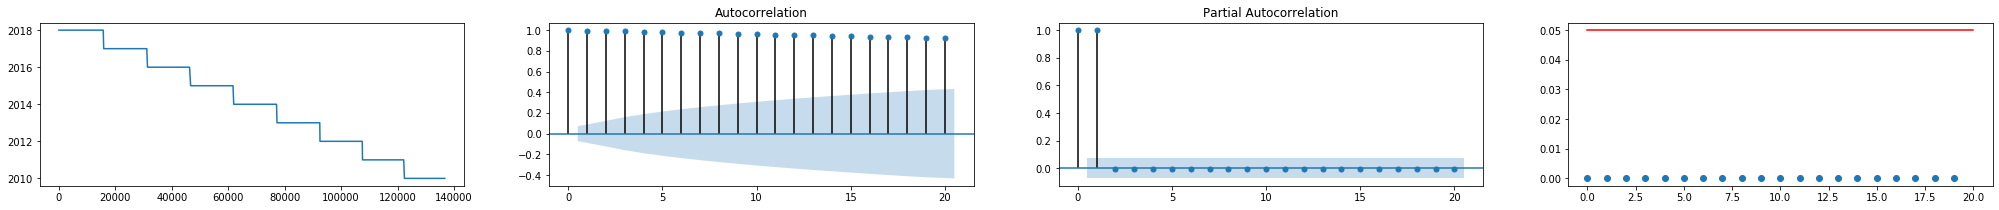

In [0]:
analyze(df.loc[df['Commodity'] == 'MEAT AND EDIBLE MEAT OFFAL.']['year'])

In [0]:
analyzeDB_attGrouping(df,True)

HSCode column, 0 out of 5
Attribute, value, length: HSCode 2 743
['year']
[19.179853042884258]
Attribute, value, length: HSCode 3 1186
['year']
[19.464847152998853]
Attribute, value, length: HSCode 4 1077
['year']
[19.418985131503366]
Attribute, value, length: HSCode 6 1125
['year']
[19.432202153489904]
Attribute, value, length: HSCode 7 1436
['year']
[19.561664975701266]
Attribute, value, length: HSCode 8 1413
['year']
[19.54489123417856]
Attribute, value, length: HSCode 9 1620
['year']
[19.608254808267432]
Attribute, value, length: HSCode 10 1501
['year']
[19.568773032223962]
Attribute, value, length: HSCode 11 1341
['year']
[19.510466137515]
Attribute, value, length: HSCode 12 1536
['year']
[19.579377108286952]
Attribute, value, length: HSCode 13 1430
['year']
[19.559554309217027]
Attribute, value, length: HSCode 14 1093
['year']
[19.442742718833184]
Attribute, value, length: HSCode 15 1399
['year']
[19.544640637556363]
Attribute, value, length: HSCode 17 1498
['year']
[19.578447095

,% data,groups,avg_temp_att,std,avg_corr,max_corr
HSCode,100,98,1.000000,0.000000,19.292170,19.682682
Commodity,100,98,1.000000,0.000000,19.292170,19.682682
value,76,1221,1.507781,0.520801,3.659734,19.960693
country,99,241,1.917012,0.275863,16.696518,19.285714
year,100,9,1.000000,0.000000,4.208747,4.936197
no-grouping,100,1,2.000000,0.000000,12.194756,19.995395


#### NEW YORK AIRBNB DATASET

In [0]:
!kaggle datasets download -d dgomonov/new-york-city-airbnb-open-data
zf = zipfile.ZipFile('new-york-city-airbnb-open-data.zip') 
df = pd.read_csv(zf.open('AB_NYC_2019.csv'),sep=',')
df

new-york-city-airbnb-open-data.zip: Skipping, found more recently modified local copy (use --force to force download)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2


In [0]:
t,c = analyzeDB(df) 
print(t)
print(c)

['id', 'calculated_host_listings_count']
[19.98812496775153, 1.0813046312580794]


In [0]:
analyzeDB_attGrouping(df)

Attribute, value, length: name Loft Suite @ The Box House Hotel 11
['id', 'longitude']
[0.6988965614523086, 0.6286294109408496]
Attribute, value, length: name Private room 10
['id']
[0.689701148694321]
Attribute, value, length: name Home away from home 17
['id', 'host_id']
[0.7859864343507422, 0.6521377188975174]
Attribute, value, length: name Hillside Hotel 18
['id']
[0.5084167415619931]
Attribute, value, length: name Artsy Private BR in Fort Greene Cumberland 10
['id']
[0.6317935683978326]
Attribute, value, length: host_id 310670 13
['id', 'number_of_reviews']
[0.7476491419741692, 0.7078737317971769]
Attribute, value, length: host_id 417504 28
['id']
[0.6326775467147278]
Attribute, value, length: host_id 836168 11
['id']
[0.7621340286907609]
Attribute, value, length: host_id 1475015 52
['id']
[2.242063838370393]
Attribute, value, length: host_id 3250450 18
['id']
[0.6896848087791324]
Attribute, value, length: host_id 7245581 19
['id', 'number_of_reviews', 'reviews_per_month']
[0.6521

#### AVOCADO PRICES DATASET

In [0]:
!kaggle datasets download -d neuromusic/avocado-prices
zf = zipfile.ZipFile('avocado-prices.zip') 
df = pd.read_csv(zf.open('avocado.csv'),sep=',')
df

  0% 0.00/629k [00:00<?, ?B/s]
100% 629k/629k [00:00<00:00, 40.7MB/s]


,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,7,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico
18245,8,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico
18246,9,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico
18247,10,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico


In [0]:
t,c = analyzeDB(df) 
print(t)
print(c)

['Unnamed: 0', 'AveragePrice', 'Total Volume', '4046', '4225', '4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'year']
[3.565579696999609, 12.752879243846374, 15.37068488776843, 15.513640518305014, 15.162104015146044, 14.716660545374827, 15.00923473556157, 14.828037705299446, 14.749649808137942, 7.768716811487909, 19.871383342556847]


In [0]:
analyzeDB_attGrouping(df)

Attribute, value, length: Unnamed: 0 0 432
['AveragePrice', 'year']
[1.5510779390262204, 16.208333333333332]
Attribute, value, length: Unnamed: 0 1 432
['AveragePrice', 'year']
[3.139469887993033, 16.208333333333332]
Attribute, value, length: Unnamed: 0 2 432
['AveragePrice', 'year']
[0.5312227337757646, 16.208333333333332]
Attribute, value, length: Unnamed: 0 3 432
['AveragePrice', 'year']
[5.816500589108339, 16.208333333333332]
Attribute, value, length: Unnamed: 0 4 432
['AveragePrice', 'year']
[2.0588630239645163, 16.208333333333332]
Attribute, value, length: Unnamed: 0 5 432
['year']
[16.208333333333332]
Attribute, value, length: Unnamed: 0 6 432
['AveragePrice', 'year']
[4.702838336593187, 16.208333333333332]
Attribute, value, length: Unnamed: 0 7 432
['AveragePrice', 'year']
[8.045605742335551, 16.208333333333332]
Attribute, value, length: Unnamed: 0 8 432
['AveragePrice', 'year']
[5.8774698101590035, 16.208333333333332]
Attribute, value, length: Unnamed: 0 9 432
['AveragePrice',

In [0]:
d = analyzeDB_attGrouping(df)

In [0]:
import copy
d1 = copy.deepcopy(d)
mx = 0
for key, value in d.items():
  l = []
  for key2, value2 in value.items():
    l = np.append(l, len(value2))
    #print(np.mean(l), np.std(l))
    if mx < np.mean(l):
      gc = key
      mx = np.mean(l)
  d1[key] = [len(l), np.mean(l), np.std(l)]
print("Most probable grouping attribute is",gc)

Most probable grouping attribute is type


In [0]:
d1

{'4046': [2, 4.5, 3.5],
 '4225': [1, 7.0, 0.0],
 '4770': [2, 5.0, 4.0],
 'AveragePrice': [182, 2.8351648351648353, 2.1573474568906246],
 'Date': [92, 1.0, 0.0],
 'Large Bags': [13, 2.769230769230769, 2.6063191301688335],
 'Small Bags': [6, 1.8333333333333333, 1.8633899812498245],
 'Total Bags': [1, 1.0, 0.0],
 'Total Volume': [0, nan, nan],
 'Unnamed: 0': [53, 1.8113207547169812, 0.3912536104401457],
 'XLarge Bags': [5, 3.6, 3.3823069050575527],
 'region': [54, 10.907407407407407, 0.28986066374997277],
 'type': [2, 11.0, 0.0],
 'year': [4, 10.0, 0.0]}

#### SUICIDE RATES DATASET

In [0]:
!kaggle datasets download -d russellyates88/suicide-rates-overview-1985-to-2016
zf = zipfile.ZipFile('suicide-rates-overview-1985-to-2016.zip') 
df = pd.read_csv(zf.open('master.csv'),sep=',')
df


suicide-rates-overview-1985-to-2016.zip: Skipping, found more recently modified local copy (use --force to force download)


,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers
...,...,...,...,...,...,...,...,...,...,...,...,...
27815,Uzbekistan,2014,female,35-54 years,107,3620833,2.96,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation X
27816,Uzbekistan,2014,female,75+ years,9,348465,2.58,Uzbekistan2014,0.675,"63,067,077,179",2309,Silent
27817,Uzbekistan,2014,male,5-14 years,60,2762158,2.17,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z
27818,Uzbekistan,2014,female,5-14 years,44,2631600,1.67,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z


In [0]:
d = analyzeDB_attGrouping(df)

In [0]:
import copy
d1 = copy.deepcopy(d)
mx = 0
for key, value in d.items():
  l = []
  for key2, value2 in value.items():
    l = np.append(l, len(value2))
    #print(np.mean(l), np.std(l))
    if mx < np.mean(l):
      gc = key
      mx = np.mean(l)
  d1[key] = [len(l), np.mean(l), np.std(l)]
print("Most probable grouping attribute is",gc)
d1


Most probable grouping attribute is sex


{' gdp_for_year ($) ': [1896, 1.396097046413502, 0.5762214682354444],
 'HDI for year': [297, 3.585858585858586, 1.5891685203472432],
 'age': [6, 4.833333333333333, 0.37267799624996495],
 'country': [100, 4.12, 0.9086253353280438],
 'country-year': [1896, 1.396097046413502, 0.5762214682354444],
 'gdp_per_capita ($)': [1838, 1.4673558215451579, 0.6878161452521971],
 'generation': [6, 5.0, 0.0],
 'population': [0, nan, nan],
 'sex': [2, 5.0, 0.0],
 'suicides/100k pop': [550, 1.1636363636363636, 0.4959338798903948],
 'suicides_no': [82, 1.3780487804878048, 0.7095213759897002],
 'year': [32, 3.65625, 0.47495887979908324]}

In [0]:
d2 = analyzeDB_attGrouping(df)

Most probable grouping attribute is country


{' gdp_for_year ($) ': [1896,
  1.396097046413502,
  0.5762214682354444,
  1.3955018410245132,
  4.0],
 'HDI for year': [297,
  3.585858585858586,
  1.5891685203472432,
  3.5674330911857064,
  6.0],
 'age': [6,
  4.833333333333333,
  0.37267799624996495,
  6.770845628277328,
  16.096241278507247],
 'country': [100,
  4.12,
  0.9086253353280438,
  4.324051361457652,
  17.650726087000965],
 'country-year': [1896,
  1.396097046413502,
  0.5762214682354444,
  1.3955018410245132,
  4.0],
 'gdp_per_capita ($)': [1838,
  1.4673558215451579,
  0.6878161452521971,
  1.4666643990568078,
  5.0],
 'generation': [6, 5.0, 0.0, 4.315807973665479, 5.767174912122828],
 'population': [0, nan, nan, nan, 0],
 'sex': [2, 5.0, 0.0, 9.161983127610881, 17.65318222834171],
 'suicides/100k pop': [550,
  1.1636363636363636,
  0.4959338798903948,
  1.162002554149477,
  4.0],
 'suicides_no': [82,
  1.3780487804878048,
  0.7095213759897002,
  1.35336163502927,
  4.0],
 'year': [32, 3.65625, 0.47495887979908324, 3.4

In [0]:
pd.DataFrame.from_dict(d3, orient='index', columns=['groups', 'mean_seq_detected', 'std', 'avg_corr', 'max_corr'])

,groups,mean_seq_detected,std,avg_corr,max_corr
country,100,4.120000,0.908625,4.324051,17.650726
year,32,3.656250,0.474959,3.454954,4.000000
sex,2,5.000000,0.000000,9.161983,17.653182
age,6,4.833333,0.372678,6.770846,16.096241
suicides_no,82,1.378049,0.709521,1.353362,4.000000
population,0,NaN,NaN,NaN,0.000000
suicides/100k pop,550,1.163636,0.495934,1.162003,4.000000
country-year,1896,1.396097,0.576221,1.395502,4.000000
HDI for year,297,3.585859,1.589169,3.567433,6.000000
gdp_for_year ($),1896,1.396097,0.576221,1.395502,4.000000


Autocorr =  True
Mann_Kendall_Test(trend='increasing', h=True, p=2.882092605682729e-06, z=4.679048505847052, Tau=0.026437138721190665, s=2557452.0, var_s=298744245324.0, slope=0.0)


(True, 11.718620218551335)

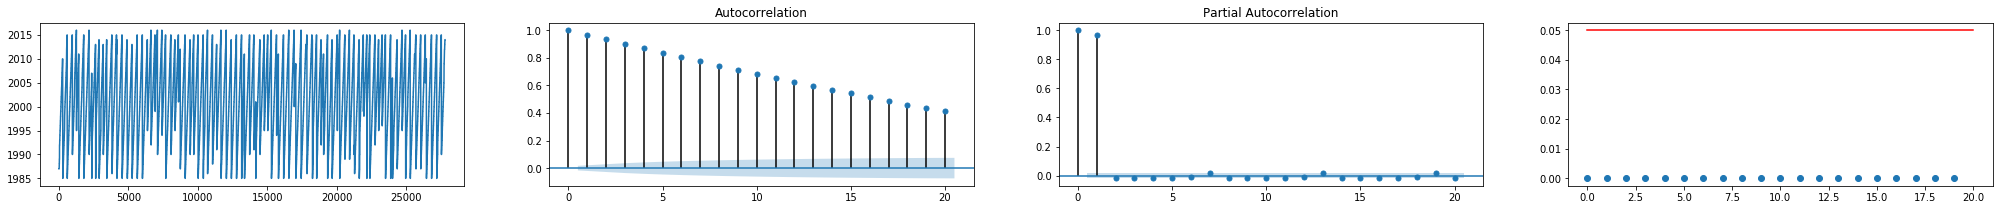

In [0]:
analyze(df.loc[df['sex'] == 'male']['year'])

[False  True False]


0.5159090909090909

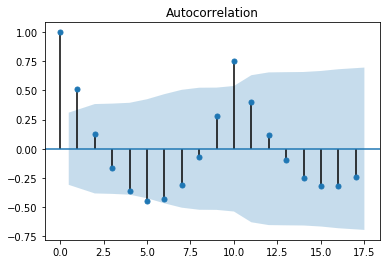

In [0]:
serie=np.array([0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9])

acf_x, confint = acf(serie, nlags=2, alpha=0.05, fft=False, unbiased=False)
thrhld = 0.5
signif = ((acf_x > (confint[:,1]-acf_x)) | (acf_x < (confint[:,0]-acf_x))) & ((acf_x > thrhld) | (acf_x < -thrhld))
signif[0] = False
print(signif)
plot_acf(serie);
sum([x for x, y in zip(acf_x, signif) if y == True])

0.7000000000000001

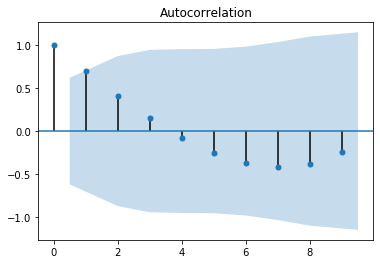

In [0]:
serie=np.array([0,1,2,3,4,5,6,7,8,9])

acf_x, confint = acf(serie, nlags=2, alpha=0.05, fft=False, unbiased=False)
thrhld = 0.5
signif = ((acf_x > (confint[:,1]-acf_x)) | (acf_x < (confint[:,0]-acf_x))) & ((acf_x > thrhld) | (acf_x < -thrhld))
signif[0] = False
plot_acf(serie);
sum([x for x, y in zip(acf_x, signif) if y == True])


In [0]:

columns = list(df) 
test=[]
acum_corr = []

for i in columns: 
  if np.issubdtype(df[i].dtype, np.number):
    ites , iacum_corr = analyze(df[i], plot=False)
    test = np.append(test, itest)
    acum_corr = np.append(acum_corr, iacum_corr)
  else:
    test = np.append(test, 0)
    acum_corr = np.append(acum_corr, 0)

cols = [x for x, y in zip(columns, test) if y == 1]
acum_corr = [x for x, y in zip(acum_corr, test) if y == 1]
return cols, acum_corr

### FOUR PATHS TO TRY

	1. CNNS ON TEMPORAL DATA
	2. FALSE POSTIVES IN CURRENT AUTOCORRELATION APPROACH
	3. LABEL ANALYSIS
	4. LIMITATION CASES OF CURRENT APPROACH

### LABEL ANALYSIS

#### CONCEPTS

  Analysing the labels for columns that may mislead our correlation approach.
  
  e.g. the __id__ is a monotonically increasing numeric column that may mislead our current approach by returning a high value of autocorellation and cross corellation.

  Simillarly, __time, date time or timestamp__ is another example column.

  We can detect columns like id or date, or columns having a large number of monotonically increasing values, and remove them to make the calculation more accurate and in decreasing the dataset to process, make the calculation faster.

  We can see after the below experiment [Metro Data Test](https://colab.research.google.com/drive/1t1QDaes5oDU_QXINx2kXiMibfb1aganL#scrollTo=LTVwiJjyGRhR), that stripping the date_time columns reduces the 4+ minute computation to a 0:01:29s minute computation

###### Mann Kendall Trend Test for Time Series

In [0]:
def mk_orig_wrapper(df):
    for col in df.columns:
        if np.issubdtype(df[col].dtype, np.number):
            print(col)
            print(df[col])
            print(df[col].dtype)
            print()
            start = datetime.now()
            print(mk.original_test(df[col]))
            print(f'time taken: {datetime.now() - start}')

#### DATASETS

!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz

!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip

### TIME SERIES BREAKDOWN

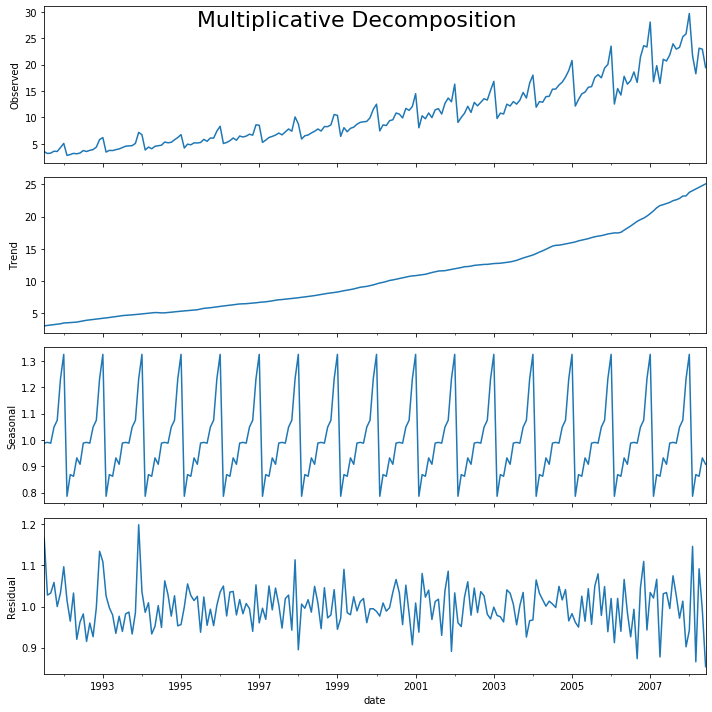

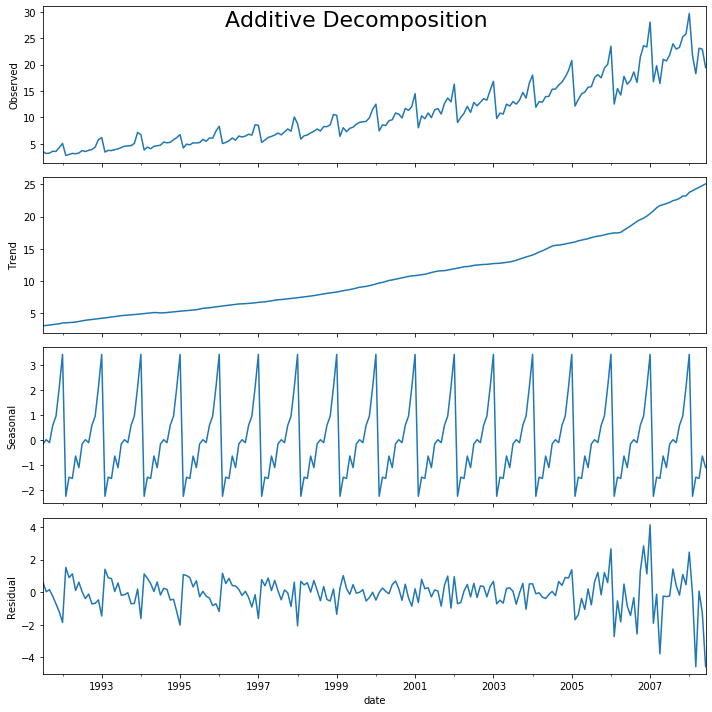

In [0]:
#def ts_decompose(df='Default')
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

#if(df='Default'):
    # Import Data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

# for col in df.columns:
#     if np.issubdtype(df[col],np.number)

# Multiplicative Decomposition 
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df['value'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decomposition', fontsize=22)
result_add.plot().suptitle('Additive Decomposition', fontsize=22)
plt.show()

#### SAN FUNCS

In [0]:
def label_analysis(df):
  import re
  from datetime import datetime
  start = datetime.now()


  cols = list(df.keys())
  stripcols = []
  df2 = None

  #clean Dataset
  # df.drop_duplicates()
  # df.dropna()

  
  for col in cols:
    id = False
    time = False
    uniq = False
    print(col)
    
    #plain label screening
    #id columns
    if(re.match("id",col.lower())):
      print('id match')
      id = True
    #time columns
    if(re.match(".*time.*",col)):
      print('time match')
      time = True
    #columns with name day, month or year
    if(re.match(".*day.*",col) or re.match(".*month.*",col) or re.match(".*year.*",col) or re.match(".*date.*",col) or pd.api.types.is_datetime64_any_dtype(df[col])):
      print('date match')
      time = True
    #columns with name day, month or year
    if(pd.api.types.is_datetime64_any_dtype(df[col])):
      print('date match')
      time = True

    #rule based screening
   
    #cols with unique values ~ len(df)
    if(len(df[col].unique()) >= 0.90*len(df)):
      print('uniq')
      uniq = True
   
   #cols with monotonically increasing values
   #NEED TO DETECT TREND
   #CAN USE MANN KENDALL OR LINEAR REGRESSION
   
    
    if id or time or uniq:   #if id or time or uniq: 
      print('appending')
      stripcols.append(col)

    print('\n')

  return stripcols  
  
  print(f'{datetime.now() - start}')


#### SANKDBOX

###### METRO DATA TEST

In [0]:
df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv.gz', compression='gzip')
df

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...,...
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450


In [0]:
df[:1]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545


In [0]:
df.keys()

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time', 'traffic_volume'],
      dtype='object')

In [0]:
[pd.api.types.is_datetime64_dtype(df['date_time']),pd.api.types.is_datetime64_any_dtype(df['date_time']),pd.api.types.is_datetime64_ns_dtype(df['date_time']),pd.api.types.is_datetime64tz_dtype(df['date_time']),pd.api.types.is_datetimetz(df['date_time'])]

[False, False, False, False, False]

In [0]:
label_analysis(df)

holiday
date match
appending


temp


rain_1h


snow_1h


clouds_all


weather_main


weather_description


date_time
time match
date match
appending


traffic_volume




['holiday', 'date_time']

In [0]:
X,Y = analyzeDB(df)
print(f'cols: {X}')
print(f'acum_corr: {Y}')

cols: ['temp', 'snow_1h', 'clouds_all', 'traffic_volume']
acum_corr: [17.181524524850357, 2.109439591692098, 4.5555072985055425, 2.237977718586252]


In [0]:
t,c = analyzeDB(df) 
l = []
l = np.append(l, len(c))
l2 = np.append(l, c)
maxl2=np.max(c)
[len(l), np.mean(l), np.std(l), np.mean(l2), maxl2]

[1, 4.0, 0.0, 6.01688982672685, 17.181524524850357]

In [0]:
analyzeDB_attGrouping(df)

holiday column, 0 out of 9
temp column, 1 out of 9
rain_1h column, 2 out of 9
snow_1h column, 3 out of 9
clouds_all column, 4 out of 9
weather_main column, 5 out of 9
weather_description column, 6 out of 9
date_time column, 7 out of 9
traffic_volume column, 8 out of 9
Most probable grouping attribute is: holiday
0:04:11.712294


,% data,groups,avg_temp_att,std,avg_corr,max_corr
holiday,99,1,4.000000,0.000000,8.589286,17.178572
temp,41,1303,1.192632,0.465749,1.279268,14.062500
rain_1h,98,56,1.678571,0.983927,2.975698,19.179688
snow_1h,99,5,2.000000,0.894427,3.448541,17.179340
clouds_all,99,34,2.147059,0.732937,4.838004,18.470961
weather_main,99,9,3.111111,0.874890,12.540115,18.057473
weather_description,99,24,2.166667,1.105542,8.800022,17.522695
date_time,0,1,1.000000,0.000000,0.416667,0.833333
traffic_volume,12,391,1.122762,0.350766,0.641085,1.127750
no-grouping,100,1,4.000000,0.000000,6.521112,17.181525


In [0]:
stripcols = label_analysis(df)
if (stripcols):
  strip = input(f'stripping the following columns {stripcols} (y/n/comma separated list of columns)?')
  print(df)
  if strip.lower() == 'y':
      for i in stripcols:   
        df = df.drop(list(stripcols),axis=1)
  elif strip.lower() == 'n':
     pass
  else:
      for i in strip.split(sep=","):   
        if i in df.keys():
          print('column exists')
          df = df.drop(i,axis=1)

print(df)

holiday
date match
appending


temp


rain_1h


snow_1h


clouds_all


weather_main


weather_description


date_time
time match
date match
appending


traffic_volume


stripping the following columns ['holiday', 'date_time'] (y/n/comma separated list of columns)?date_time
      holiday    temp  ...            date_time  traffic_volume
0        None  288.28  ...  2012-10-02 09:00:00            5545
1        None  289.36  ...  2012-10-02 10:00:00            4516
2        None  289.58  ...  2012-10-02 11:00:00            4767
3        None  290.13  ...  2012-10-02 12:00:00            5026
4        None  291.14  ...  2012-10-02 13:00:00            4918
...       ...     ...  ...                  ...             ...
48199    None  283.45  ...  2018-09-30 19:00:00            3543
48200    None  282.76  ...  2018-09-30 20:00:00            2781
48201    None  282.73  ...  2018-09-30 21:00:00            2159
48202    None  282.09  ...  2018-09-30 22:00:00            1450
48203    None  282.12 

In [0]:
analyzeDB_attGrouping(df)

holiday column, 0 out of 8
temp column, 1 out of 8
rain_1h column, 2 out of 8
snow_1h column, 3 out of 8
clouds_all column, 4 out of 8
weather_main column, 5 out of 8
weather_description column, 6 out of 8
traffic_volume column, 7 out of 8
Most probable grouping attribute is: holiday
0:01:30.192457


,% data,groups,avg_temp_att,std,avg_corr,max_corr
holiday,99,1,4.000000,0.000000,8.589286,17.178572
temp,41,1303,1.192632,0.465749,1.279268,14.062500
rain_1h,98,56,1.678571,0.983927,2.975698,19.179688
snow_1h,99,5,2.000000,0.894427,3.448541,17.179340
clouds_all,99,34,2.147059,0.732937,4.838004,18.470961
weather_main,99,9,3.111111,0.874890,12.540115,18.057473
weather_description,99,24,2.166667,1.105542,8.800022,17.522695
traffic_volume,12,391,1.122762,0.350766,0.641085,1.127750
no-grouping,100,1,4.000000,0.000000,6.521112,17.181525


In [0]:
df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv.gz', compression='gzip')
df
mk_orig_wrapper(df)

temp
0        288.28
1        289.36
2        289.58
3        290.13
4        291.14
          ...  
48199    283.45
48200    282.76
48201    282.73
48202    282.09
48203    282.12
Name: temp, Length: 48204, dtype: float64
float64

Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=35.87119205014844, Tau=0.10892529282342671, s=126548175.0, var_s=12445723483611.0, slope=0.0001506818910454008)
time taken: 0:00:32.705215
rain_1h
0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
48199    0.0
48200    0.0
48201    0.0
48202    0.0
48203    0.0
Name: rain_1h, Length: 48204, dtype: float64
float64

Mann_Kendall_Test(trend='decreasing', h=True, p=6.772360450213455e-14, z=-7.49209843417488, Tau=-0.01018982878630256, s=-11838428.0, var_s=2496784454204.0, slope=0.0)
time taken: 0:00:23.417970
snow_1h
0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
48199    0.0
48200    0.0
48201    0.0
48202    0.0
48203    0.0
Name: snow_1h, Length: 4


###### BANK DATASET EXAMPLE

In [0]:
zf = zipfile.ZipFile('bank.zip') 
df = pd.read_csv(zf.open('bank.csv'),sep=';')
df

In [0]:
 df['age'].unique(),len(df['age'].unique())

(array([30, 33, 35, 59, 36, 39, 41, 43, 20, 31, 40, 56, 37, 25, 38, 42, 44,
        26, 55, 67, 53, 68, 32, 49, 78, 23, 52, 34, 61, 45, 48, 57, 54, 63,
        51, 29, 50, 27, 60, 28, 21, 58, 22, 46, 24, 77, 75, 47, 70, 65, 64,
        62, 66, 19, 81, 83, 80, 71, 72, 69, 79, 73, 86, 74, 76, 87, 84]), 67)

In [0]:
 df['job'].unique(),len(df['job'].unique())

(array(['unemployed', 'services', 'management', 'blue-collar',
        'self-employed', 'technician', 'entrepreneur', 'admin.', 'student',
        'housemaid', 'retired', 'unknown'], dtype=object), 12)

In [0]:
 df['marital'].unique(),len(df['marital'].unique())

(array(['married', 'single', 'divorced'], dtype=object), 3)

In [0]:
 df['education'].unique(),len(df['education'].unique())

(array(['primary', 'secondary', 'tertiary', 'unknown'], dtype=object), 4)

In [0]:
len(df['balance'].unique())

2353

In [0]:
 len(df['duration'].unique())

875

In [0]:
len(df['pdays'].unique())

292

In [0]:
analyzeDB_attGrouping(df)

In [0]:
stripcols = label_analysis(df)
strip = input(f'stripping the following columns {stripcols} (y/n/comma separated list of columns)?')
print(f'strip: {strip}')
print(df)
if strip.lower() == 'y':
    for i in stripcols:   
      df = df.drop(list(stripcols),axis=1)
elif strip.lower() == 'n':
   pass
else:
    for i in strip.split(sep=","):   
      if i in df.keys():
        print('exists')
        df = df.drop(i,axis=1)

print(df)

In [0]:
analyzeDB_attGrouping(df)

In [0]:
zf = zipfile.ZipFile('bank.zip') 
df = pd.read_csv(zf.open('bank.csv'),sep=';')
mk_orig_wrapper(df)

age
0       30
1       33
2       35
3       30
4       59
        ..
4516    33
4517    57
4518    57
4519    28
4520    44
Name: age, Length: 4521, dtype: int64
int64

Mann_Kendall_Test(trend='no trend', h=False, p=0.6572106867221352, z=0.4437675015623613, Tau=0.0043995278670041285, s=44952.0, var_s=10260481145.333334, slope=0.0)
time taken: 0:00:00.521897
balance
0       1787
1       4789
2       1350
3       1476
4          0
        ... 
4516    -333
4517   -3313
4518     295
4519    1137
4520    1136
Name: balance, Length: 4521, dtype: int64
int64

Mann_Kendall_Test(trend='no trend', h=False, p=0.41288237244101067, z=-0.8188318220776378, Tau=-0.008119924129871808, s=-82965.0, var_s=10265732448.333334, slope=-0.0008514865578953461)
time taken: 0:00:00.488215
day
0       19
1       11
2       16
3        3
4        5
        ..
4516    30
4517     9
4518    19
4519     6
4520     3
Name: day, Length: 4521, dtype: int64
int64

Mann_Kendall_Test(trend='no trend', h=False, p=0.8195963

##### MARKET ARRIVALS DATASET

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/MarketArrivals.csv')
mk_orig_wrapper(df)

year
0        2005
1        2006
2        2010
3        2011
4        2012
         ... 
10222    2011
10223    2012
10224    2013
10225    2014
10226    2015
Name: year, Length: 10227, dtype: int64
int64

Mann_Kendall_Test(trend='decreasing', h=True, p=0.0, z=-8.388638582532385, Tau=-0.05516796874454671, s=-2884769.0, var_s=118260256493.66667, slope=0.0)
time taken: 0:00:01.784407
quantity
0          2350
1           900
2           790
3           245
4          1035
          ...  
10222    131326
10223    207066
10224    215883
10225    201077
10226    223315
Name: quantity, Length: 10227, dtype: int64
int64

Mann_Kendall_Test(trend='increasing', h=True, p=0.0012015956191748778, z=3.238501089789127, Tau=0.021352727086912725, s=1116548.0, var_s=118868264770.0, slope=0.2599223738575185)
time taken: 0:00:01.848644
priceMin
0         404
1         487
2        1283
3        3067
4         523
         ... 
10222     282
10223     485
10224     472
10225     446
10226     609
Name: pric

In [0]:
df.columns

Index(['market', 'month', 'year', 'quantity', 'priceMin', 'priceMax',
       'priceMod', 'state', 'city', 'date'],
      dtype='object')

##### INDIA TRADE DATASET

In [0]:
!kaggle datasets download -d lakshyaag/india-trade-data
zf = zipfile.ZipFile('india-trade-data.zip') 
df = pd.read_csv(zf.open('2018-2010_export.csv'),sep=',')
df = pd.DataFrame(data=df['HSCode'][:10000])
df
mk_orig_wrapper(df)

india-trade-data.zip: Skipping, found more recently modified local copy (use --force to force download)
HSCode
0        2
1        3
2        4
3        6
4        7
        ..
9995    15
9996    16
9997    17
9998    18
9999    19
Name: HSCode, Length: 10000, dtype: int64
int64

Mann_Kendall_Test(trend='no trend', h=False, p=0.358695884312938, z=0.9178528973147511, Tau=0.00611971197119712, s=305955.0, var_s=111113314981.66667, slope=0.0)
time taken: 0:00:01.589376


In [0]:
df.loc[df['HSCode'] == 2]

,HSCode,Commodity,value,country,year
0,2,MEAT AND EDIBLE MEAT OFFAL.,0.18,AFGHANISTAN TIS,2018
147,2,MEAT AND EDIBLE MEAT OFFAL.,50.75,ALGERIA,2018
275,2,MEAT AND EDIBLE MEAT OFFAL.,27.31,ANGOLA,2018
510,2,MEAT AND EDIBLE MEAT OFFAL.,2.28,ARMENIA,2018
808,2,MEAT AND EDIBLE MEAT OFFAL.,0.51,AZERBAIJAN,2018
...,...,...,...,...,...
136258,2,MEAT AND EDIBLE MEAT OFFAL.,NaN,UNION OF SERBIA & MONTENEGRO,2010
136319,2,MEAT AND EDIBLE MEAT OFFAL.,0.06,UNSPECIFIED,2010
136483,2,MEAT AND EDIBLE MEAT OFFAL.,2.19,UZBEKISTAN,2010
136647,2,MEAT AND EDIBLE MEAT OFFAL.,281.65,VIETNAM SOC REP,2010


In [0]:
df.loc[df['HSCode'] == 4]

,HSCode,Commodity,value,country,year
2,4,DAIRY PRODUCE; BIRDS' EGGS; NATURAL HONEY; EDI...,12.48,AFGHANISTAN TIS,2018
149,4,DAIRY PRODUCE; BIRDS' EGGS; NATURAL HONEY; EDI...,0.00,ALGERIA,2018
245,4,DAIRY PRODUCE; BIRDS' EGGS; NATURAL HONEY; EDI...,0.00,ANDORRA,2018
277,4,DAIRY PRODUCE; BIRDS' EGGS; NATURAL HONEY; EDI...,0.05,ANGOLA,2018
424,4,DAIRY PRODUCE; BIRDS' EGGS; NATURAL HONEY; EDI...,NaN,ARGENTINA,2018
...,...,...,...,...,...
136079,4,DAIRY PRODUCE; BIRDS' EGGS; NATURAL HONEY; EDI...,0.00,UGANDA,2010
136321,4,DAIRY PRODUCE; BIRDS' EGGS; NATURAL HONEY; EDI...,0.30,UNSPECIFIED,2010
136649,4,DAIRY PRODUCE; BIRDS' EGGS; NATURAL HONEY; EDI...,3.12,VIETNAM SOC REP,2010
136771,4,DAIRY PRODUCE; BIRDS' EGGS; NATURAL HONEY; EDI...,4.10,YEMEN REPUBLC,2010


In [0]:
df['HSCode'].unique()

array([ 2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 44, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59,
       60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 78,
       79, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 94, 95, 96, 97, 98,
       99,  5, 43, 26, 45, 75, 80, 93, 89, 46, 51, 16,  1])

### FALSE POSTIVES IN CURRENT AUTOCORRELATION APPROACH